# Montar Drive + Imports

In [ ]:
!pip install neuroCombat

In [ ]:
import os
import pandas as pd
from google.colab import drive
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from neuroCombat import neuroCombat
import seaborn as sns
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from typing import List, Dict

In [ ]:
# 1. Montar Google Drive
print("Paso 1: Montando Google Drive...")
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Máster - Data Science/TFM/Data/ESTUDIO_MULTIPLEX')

Paso 1: Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Función de recuperación de información + listar pacientes

In [ ]:
def obtener_datos_paciente(id_paciente: str, base_dir: str = ".", vars_info: list[str] = None):
    """
    Devuelve un diccionario con la información clínica, nodos procesados, nodos_FA, nodos_MD y redes
    de un paciente dado su ID. Permite seleccionar qué variables incluir en info_clinica.

    Args:
        id_paciente (str): ID del paciente (por ejemplo, '002MSVIS')
        base_dir (str): Carpeta base donde se encuentra patients.csv y las carpetas DADES_{origen}
        vars_info (list[str], opcional): Lista de columnas a incluir en info_clinica.
                                          Si es None, se devuelven todas las columnas disponibles.

    Returns:
        dict: Estructura con origen, info_clinica, nodos_volumetrico, nodos_FA, nodos_MD y redes.
    """

    # 1️⃣ Leer el archivo de pacientes para obtener el origen
    patients_path = os.path.join(base_dir, "patients.csv")
    df_patients = pd.read_csv(patients_path)
    origen_row = df_patients.loc[df_patients["id_paciente"] == id_paciente]

    if origen_row.empty:
        raise ValueError(f"No se encontró el paciente {id_paciente} en patients.csv")

    origen = origen_row.iloc[0]["origen"]
    dades_dir = os.path.join(base_dir, f"DADES_{origen}")

    # 2️⃣ Obtener info_clinica
    clinic_path = os.path.join(dades_dir, f"CLINIC_{origen}.csv")
    df_clinic = pd.read_csv(clinic_path)
    info_row = df_clinic.loc[df_clinic["id"] == id_paciente]

    if info_row.empty:
        info_clinica = None
    else:
        info_row = info_row.iloc[0]
        if vars_info:
            # Filtramos solo las variables deseadas si existen en el DataFrame
            cols_existentes = [col for col in vars_info if col in df_clinic.columns]
            info_clinica = info_row[cols_existentes].to_dict()
        else:
            # Si no se especifica lista, devolvemos todo
            info_clinica = info_row.to_dict()

    # 3️⃣ Obtener nodos_volumetrico
    def leer_nodos(nombre_archivo):
        """Función auxiliar para leer un archivo de nodos filtrando por ID y devolver los valores en orden, excepto la columna ID."""
        path = os.path.join(dades_dir, nombre_archivo)
        if os.path.exists(path):
            df = pd.read_csv(path)
            row = df.loc[df["ID"] == id_paciente]
            if not row.empty:
                # Devuelve los valores de la fila, excepto la columna 'ID'
                return row.drop(columns=["ID"]).iloc[0].tolist()
        return None

    nodos_volumetrico = leer_nodos(f"NODES_{origen}.csv")
    nodos_FA = leer_nodos(f"GM_FA_{origen}.csv")
    nodos_MD = leer_nodos(f"GM_MD_{origen}.csv")

    # 4️⃣ Cargar las redes (FA, GM, rsfmri)
    redes = {}
    for tipo_red in ["FA", "GM", "rsfmri"]:
        red_dir = os.path.join(dades_dir, f"{tipo_red}_networks")
        if tipo_red == "GM":
          matrix_path = os.path.join(red_dir, f"{id_paciente}_GM_matrix.csv")
        elif tipo_red == "rsfmri":
          matrix_path = os.path.join(red_dir, f"{id_paciente}_r_matrix.csv")
        else:
          if origen == "HCB":
            matrix_path = os.path.join(red_dir, f"{id_paciente}_FA_factor.csv")
          else:
            matrix_path = os.path.join(red_dir, f"{id_paciente}_fa_factor.csv")

        if os.path.exists(matrix_path):
            try:
                redes[tipo_red] = pd.read_csv(matrix_path, header=None).to_numpy()
            except Exception as e:
                print(f"Error al leer la red {tipo_red}: {e}")
                redes[tipo_red] = None
        else:
            redes[tipo_red] = None

    # 🧩 Estructura final
    resultado = {
        "origen": origen,
        "info_clinica": info_clinica,
        "nodos_volumetrico": nodos_volumetrico,
        "nodos_FA": nodos_FA,
        "nodos_MD": nodos_MD,
        "redes": redes
    }

    return resultado

In [ ]:
def listar_pacientes(base_dir: str = ".") -> list[str]:
    """
    Devuelve una lista con todos los valores de 'id_paciente' del archivo patients.csv.

    Args:
        base_dir (str): Carpeta base donde se encuentra patients.csv

    Returns:
        list[str]: Lista de IDs de pacientes.
    """
    patients_path = os.path.join(base_dir, "patients.csv")

    if not os.path.exists(patients_path):
        raise FileNotFoundError(f"No se encontró el archivo: {patients_path}")

    df_patients = pd.read_csv(patients_path)

    if "id_paciente" not in df_patients.columns:
        raise ValueError("El archivo patients.csv no contiene la columna 'id_paciente'.")

    # Elimina valores nulos y los convierte a string
    ids = df_patients["id_paciente"].dropna().astype(str).tolist()

    return ids

pacientes = listar_pacientes()

# Revisión de datos

Los datos devueltos por la recuperación tienen el formato:

{
    'origen': str,                 # Nombre o fuente de los datos, ej. 'HCB'
    
    'info_clinica': {              # Información clínica del paciente
        'id': str,                 # Identificador del paciente
        'age': float,              # Edad
        'sex': int,                # Sexo codificado (1 o 2)
        'dd': float,               # Duración de la enfermedad (años)
        'edss': float,             # Puntaje EDSS
        'control_ms': int,         # 0 si no hay control MS, 1 si hay
        'mstype': int               # Tipo de MS: 0=RRMS, 1=SPMS, 2=PPMS
    },
    
    'nodos_volumetrico': list,      # Lista de valores volumen por nodo (IDs + int)
    
    'nodos_FA': list,              # Lista de valores FA por nodo (IDs + float64)
    
    'nodos_MD': list,              # Lista de valores MD por nodo (IDs + float64)
    
    'redes': {                     # Diccionario de matrices de conectividad
        'FA': np.ndarray,          # Matriz FA (num_nodos x num_nodos)
        'GM': np.ndarray,          # Matriz GM (num_nodos x num_nodos)
        'rsfmri': np.ndarray       # Matriz rs-fMRI (num_nodos x num_nodos)
    }
}


In [ ]:
# Selección de variables de información
vars_info = ["id", "age", "sex", "controls_ms", "mstype", "dd", "edss"]

# Iterar y revisar que no haya nulos con barra de progreso
for paciente in tqdm(pacientes, desc="Revisando pacientes"):
    info_paciente = obtener_datos_paciente(id_paciente=paciente, vars_info=vars_info)

    control = info_paciente['info_clinica'].get("controls_ms", 0)

    # Revisar info_clinica
    for key, value in info_paciente['info_clinica'].items():
        # Ignorar ciertos campos si control_ms es 0
        if control == 0 and key in ["mstype", "dd", "edss"]:
            continue

        if value is None or (isinstance(value, float) and np.isnan(value)):
            print(f"Nulo encontrado en {paciente} -> info_clinica[{key}]")

    # Revisar nodos_volumetrico
    if any(v is None for v in info_paciente['nodos_volumetrico']):
        print(f"Nulo encontrado en {paciente} -> nodos_volumetrico")

    # Revisar nodos_FA
    if any(v is None for v in info_paciente['nodos_FA']):
        print(f"Nulo encontrado en {paciente} -> nodos_FA")

    # Revisar nodos_MD
    if any(v is None for v in info_paciente['nodos_MD']):
        print(f"Nulo encontrado en {paciente} -> nodos_MD")

    # Revisar matrices en 'redes'
    for tipo_red, matriz in info_paciente['redes'].items():
        if matriz is None or np.isnan(matriz).any():
            print(f"Nulo encontrado en {paciente} -> redes[{tipo_red}]")

Revisando pacientes: 100%|██████████| 270/270 [00:24<00:00, 11.21it/s]


Vemos que todo es correcto ya que no contiene valores nulos.

# Preparar los datos

Obtenemos los datos en formato tensorial para procesarlos luego:

- `FA_matrices_tensor[i][j]`, `GM_matrices_tensor[i][j]` y `rsfMRI_matrices_tensor[i][j]` → lista de longitud `n_pacientes` con todos los valores de la conexión `(i,j)` para todos los pacientes.

- `nodos_volumetricos_tensor[k]`, `nodos_FA_tensor[k]` y `nodos_MD_tensor[k]` → listas de valores por nodo `k` para todos los pacientes.

- `origen`, `ages`, `sexes`, `ddes`, `edsses`, `control_mses`, `mstypes`  → arrays con las variables clínicas.

- `site`  → array con el protocolo de muestra (FIS, MSVIS o sub)

In [ ]:
# Selección de variables de información
vars_info = ["id", "age", "sex", "controls_ms", "mstype", "dd", "edss"]

# --- Obtener dimensiones base (suponiendo todos los pacientes tienen mismas dimensiones) ---
info_ref = obtener_datos_paciente(id_paciente=pacientes[0], vars_info=vars_info)
n_nodos = info_ref['redes']['FA'].shape[0]

# --- Inicializar estructuras vacías ---
FA_matrices_tensor = [[[] for _ in range(n_nodos)] for _ in range(n_nodos)]
GM_matrices_tensor = [[[] for _ in range(n_nodos)] for _ in range(n_nodos)]
rsfMRI_matrices_tensor = [[[] for _ in range(n_nodos)] for _ in range(n_nodos)]

nodos_volumetricos_tensor = [[] for _ in range(n_nodos)]
nodos_FA_tensor = [[] for _ in range(n_nodos)]
nodos_MD_tensor = [[] for _ in range(n_nodos)]

# Variables clínicas
origenes = []
ids = []
sites = []
ages = []
sexes = []
ddes = []
edsses = []
controls_mses = []
mstypes = []

# --- Iterar sobre pacientes ---
for paciente in tqdm(pacientes, desc="Construyendo tensores de conectividad"):
    info = obtener_datos_paciente(id_paciente=paciente, vars_info=vars_info)
    redes = info['redes']
    clinica = info['info_clinica']

    # Guardar variables clínicas
    origenes.append(info['origen'])
    ids.append(clinica['id'])

    if "MSVIS" in clinica['id']:
        sites.append("MSVIS")

    if "FIS" in clinica['id']:
        sites.append("FIS")

    if "sub" in clinica['id']:
        sites.append("sub")

    ages.append(clinica['age'])
    sexes.append(clinica['sex'])
    controls_mses.append(clinica['controls_ms'])
    if clinica['controls_ms'] == 0:
        ddes.append(-1)
        edsses.append(0)
        mstypes.append(-1)
    else:
        ddes.append(clinica['dd'])
        edsses.append(clinica['edss'])
        mstypes.append(clinica['mstype'])

    # --- Rellenar tensores de conectividad ---
    for i in range(n_nodos):
        for j in range(i, n_nodos):   # Solo triángulo superior (incluye diagonal)

            if i == j:
                # Diagonal
                FA_matrices_tensor[i][j].append(0)
                GM_matrices_tensor[i][j].append(0)
                rsfMRI_matrices_tensor[i][j].append(0)
            else:
                # Triángulo superior derecho
                val_fa = redes['FA'][i, j]
                val_gm = redes['GM'][i, j]
                val_rs = redes['rsfmri'][i, j]

                # Guardamos valores originales en el triángulo superior
                FA_matrices_tensor[i][j].append(val_fa)
                GM_matrices_tensor[i][j].append(val_gm)
                rsfMRI_matrices_tensor[i][j].append(val_rs)

                # Copiamos valores simétricos al triángulo inferior
                FA_matrices_tensor[j][i].append(val_fa)
                GM_matrices_tensor[j][i].append(val_gm)
                rsfMRI_matrices_tensor[j][i].append(val_rs)

    # --- Rellenar tensores de nodos ---
    for k in range(n_nodos):
        nodos_volumetricos_tensor[k].append(info['nodos_volumetrico'][k])
        nodos_FA_tensor[k].append(info['nodos_FA'][k])
        nodos_MD_tensor[k].append(info['nodos_MD'][k])


# Convertir a numpy
FA_matrices_tensor = np.array(FA_matrices_tensor) # Dimensión: (n_nodos, n_nodos, n_pacientes)
GM_matrices_tensor = np.array(GM_matrices_tensor)
rsfMRI_matrices_tensor = np.array(rsfMRI_matrices_tensor)

nodos_volumetricos_tensor = np.array(nodos_volumetricos_tensor)
nodos_FA_tensor = np.array(nodos_FA_tensor)
nodos_MD_tensor = np.array(nodos_MD_tensor)


# Convertir edad y sexo a arrays NumPy
ages = np.array(ages)
sexes = np.array(sexes)
ddes = np.array(ddes)
edsses = np.array(edsses)
controls_mses = np.array(controls_mses)
mstypes = np.array(mstypes)

Construyendo tensores de conectividad: 100%|██████████| 270/270 [00:26<00:00, 10.35it/s]


# Visualizaciones Iniciales

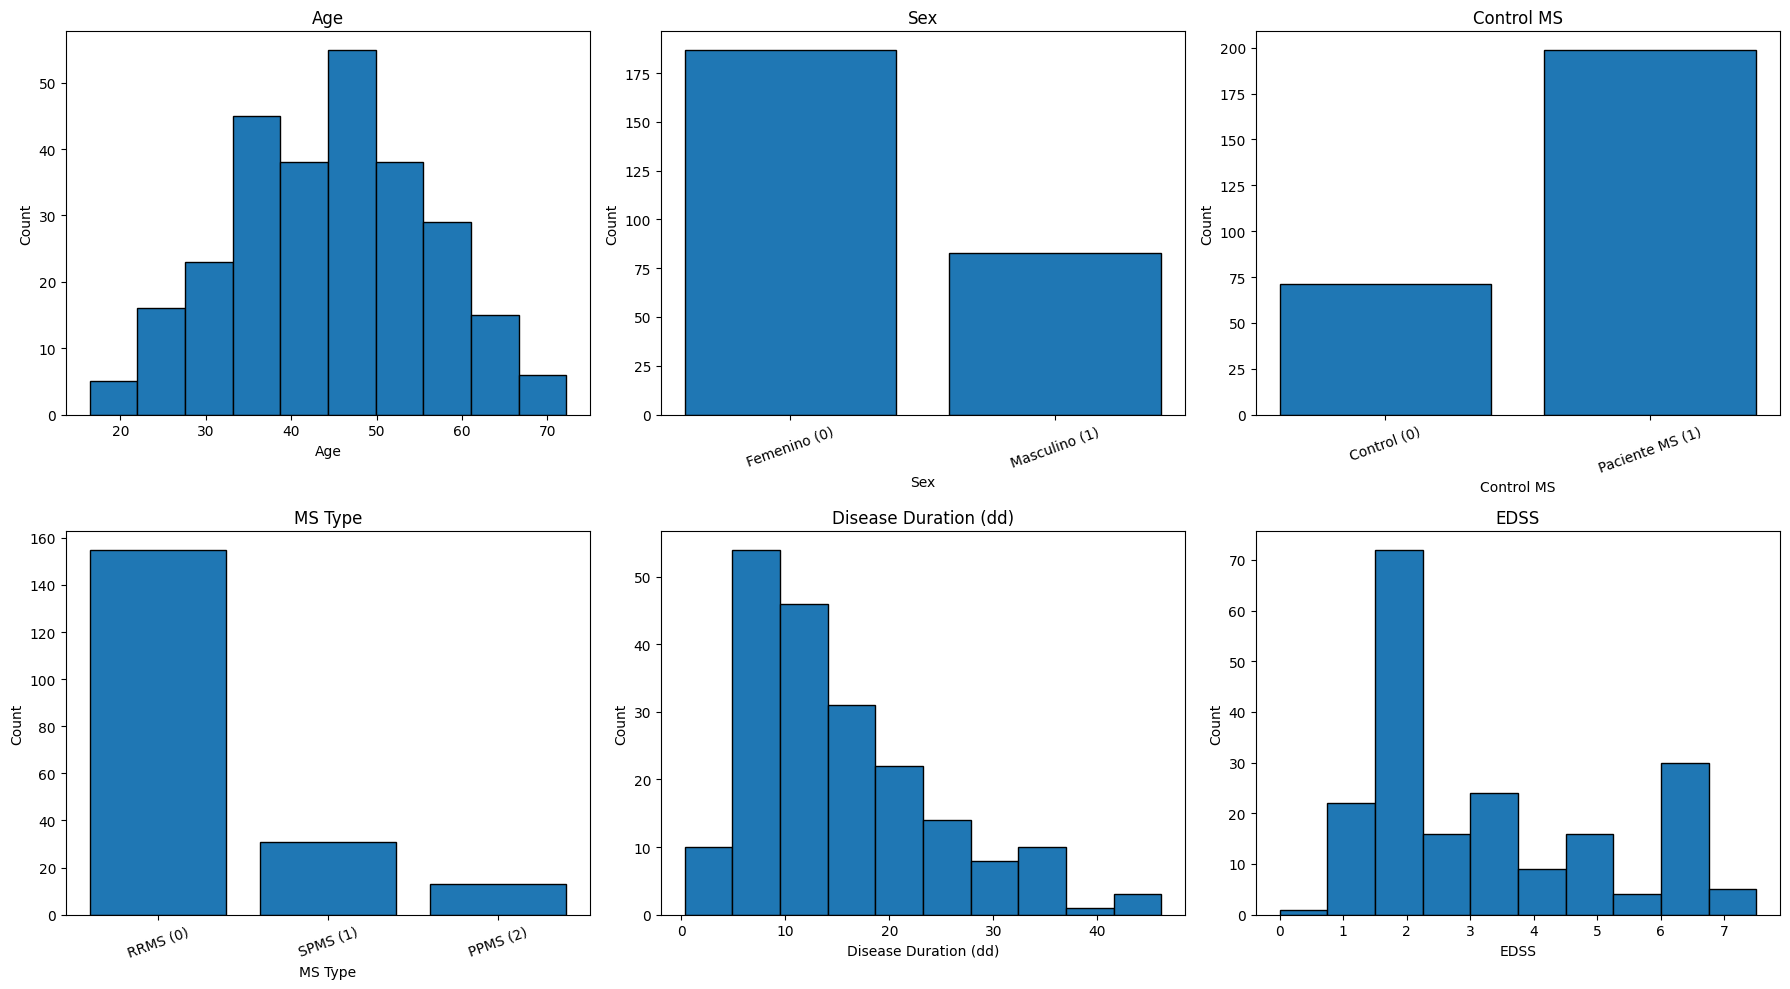

In [ ]:
# 1. Crear una lista de tuplas (variable_filtrada, control_mses) para iterar
#    sobre las variables que necesitan ser filtradas.
data_to_filter = [
    (mstypes, "MS Type"),
    (ddes, "Disease Duration (dd)"),
    (edsses, "EDSS")
]

# 2. Aplicar el filtro: solo incluir elementos donde controls_mses es 1.
#    Se usa un diccionario para almacenar los datos filtrados,
#    usando el nombre de la variable como clave.
filtered_data = {}
for data, name in data_to_filter:
    # Comprobar que todas las listas tienen la misma longitud antes de zipear
    if len(data) != len(controls_mses):
        print(f"Advertencia: Las longitudes de '{name}' y 'controls_mses' no coinciden. Se saltará el filtrado.")
        filtered_data[name] = data
        continue

    # Aplicación del filtro
    filtered_data[name] = [
        val for val, control in zip(data, controls_mses) if control == 1
    ]

# 3. Crear la lista de pares (nombre, datos) usando las listas filtradas
variables = [
    ("Age", ages),                     # Sin filtrar
    ("Sex", sexes),                    # Sin filtrar
    ("Control MS", controls_mses),     # Sin filtrar
    ("MS Type", filtered_data["MS Type"]),
    ("Disease Duration (dd)", filtered_data["Disease Duration (dd)"]),
    ("EDSS", filtered_data["EDSS"])
]

# Variables que quieres tratar como categóricas (aunque sean numéricas)
categorical_vars = ["Sex", "Control MS", "MS Type"]

# Diccionarios de etiquetas para variables categóricas
category_labels = {
    "Sex": {
        0: "Femenino (0)",
        1: "Masculino (1)"
    },
    "Control MS": {
        0: "Control (0)",
        1: "Paciente MS (1)"
    },
    "MS Type": {
        -1: "Sano (-1)",
        0: "RRMS (0)",
        1: "SPMS (1)",
        2: "PPMS (2)"
    }
}

# Crear subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, data) in zip(axes, variables):
    data = [d for d in data if d is not None]  # Filtrar None

    if len(data) == 0:
        ax.set_title(f"{name}\n(sin datos)")
        ax.axis('off')
        continue

    if name in categorical_vars:
        # Contar frecuencias
        counts = Counter(data)
        categories = sorted(counts.keys())
        values = [counts[c] for c in categories]

        # Usar etiquetas personalizadas si existen
        if name in category_labels:
            tick_labels = [category_labels[name].get(c, str(c)) for c in categories]
        else:
            tick_labels = [str(c) for c in categories]

        ax.bar(range(len(categories)), values, edgecolor='black')
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels(tick_labels, rotation=20)
    else:
        # Variable continua
        ax.hist(data, bins=10, edgecolor='black')

    ax.set_title(name)
    ax.set_xlabel(name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

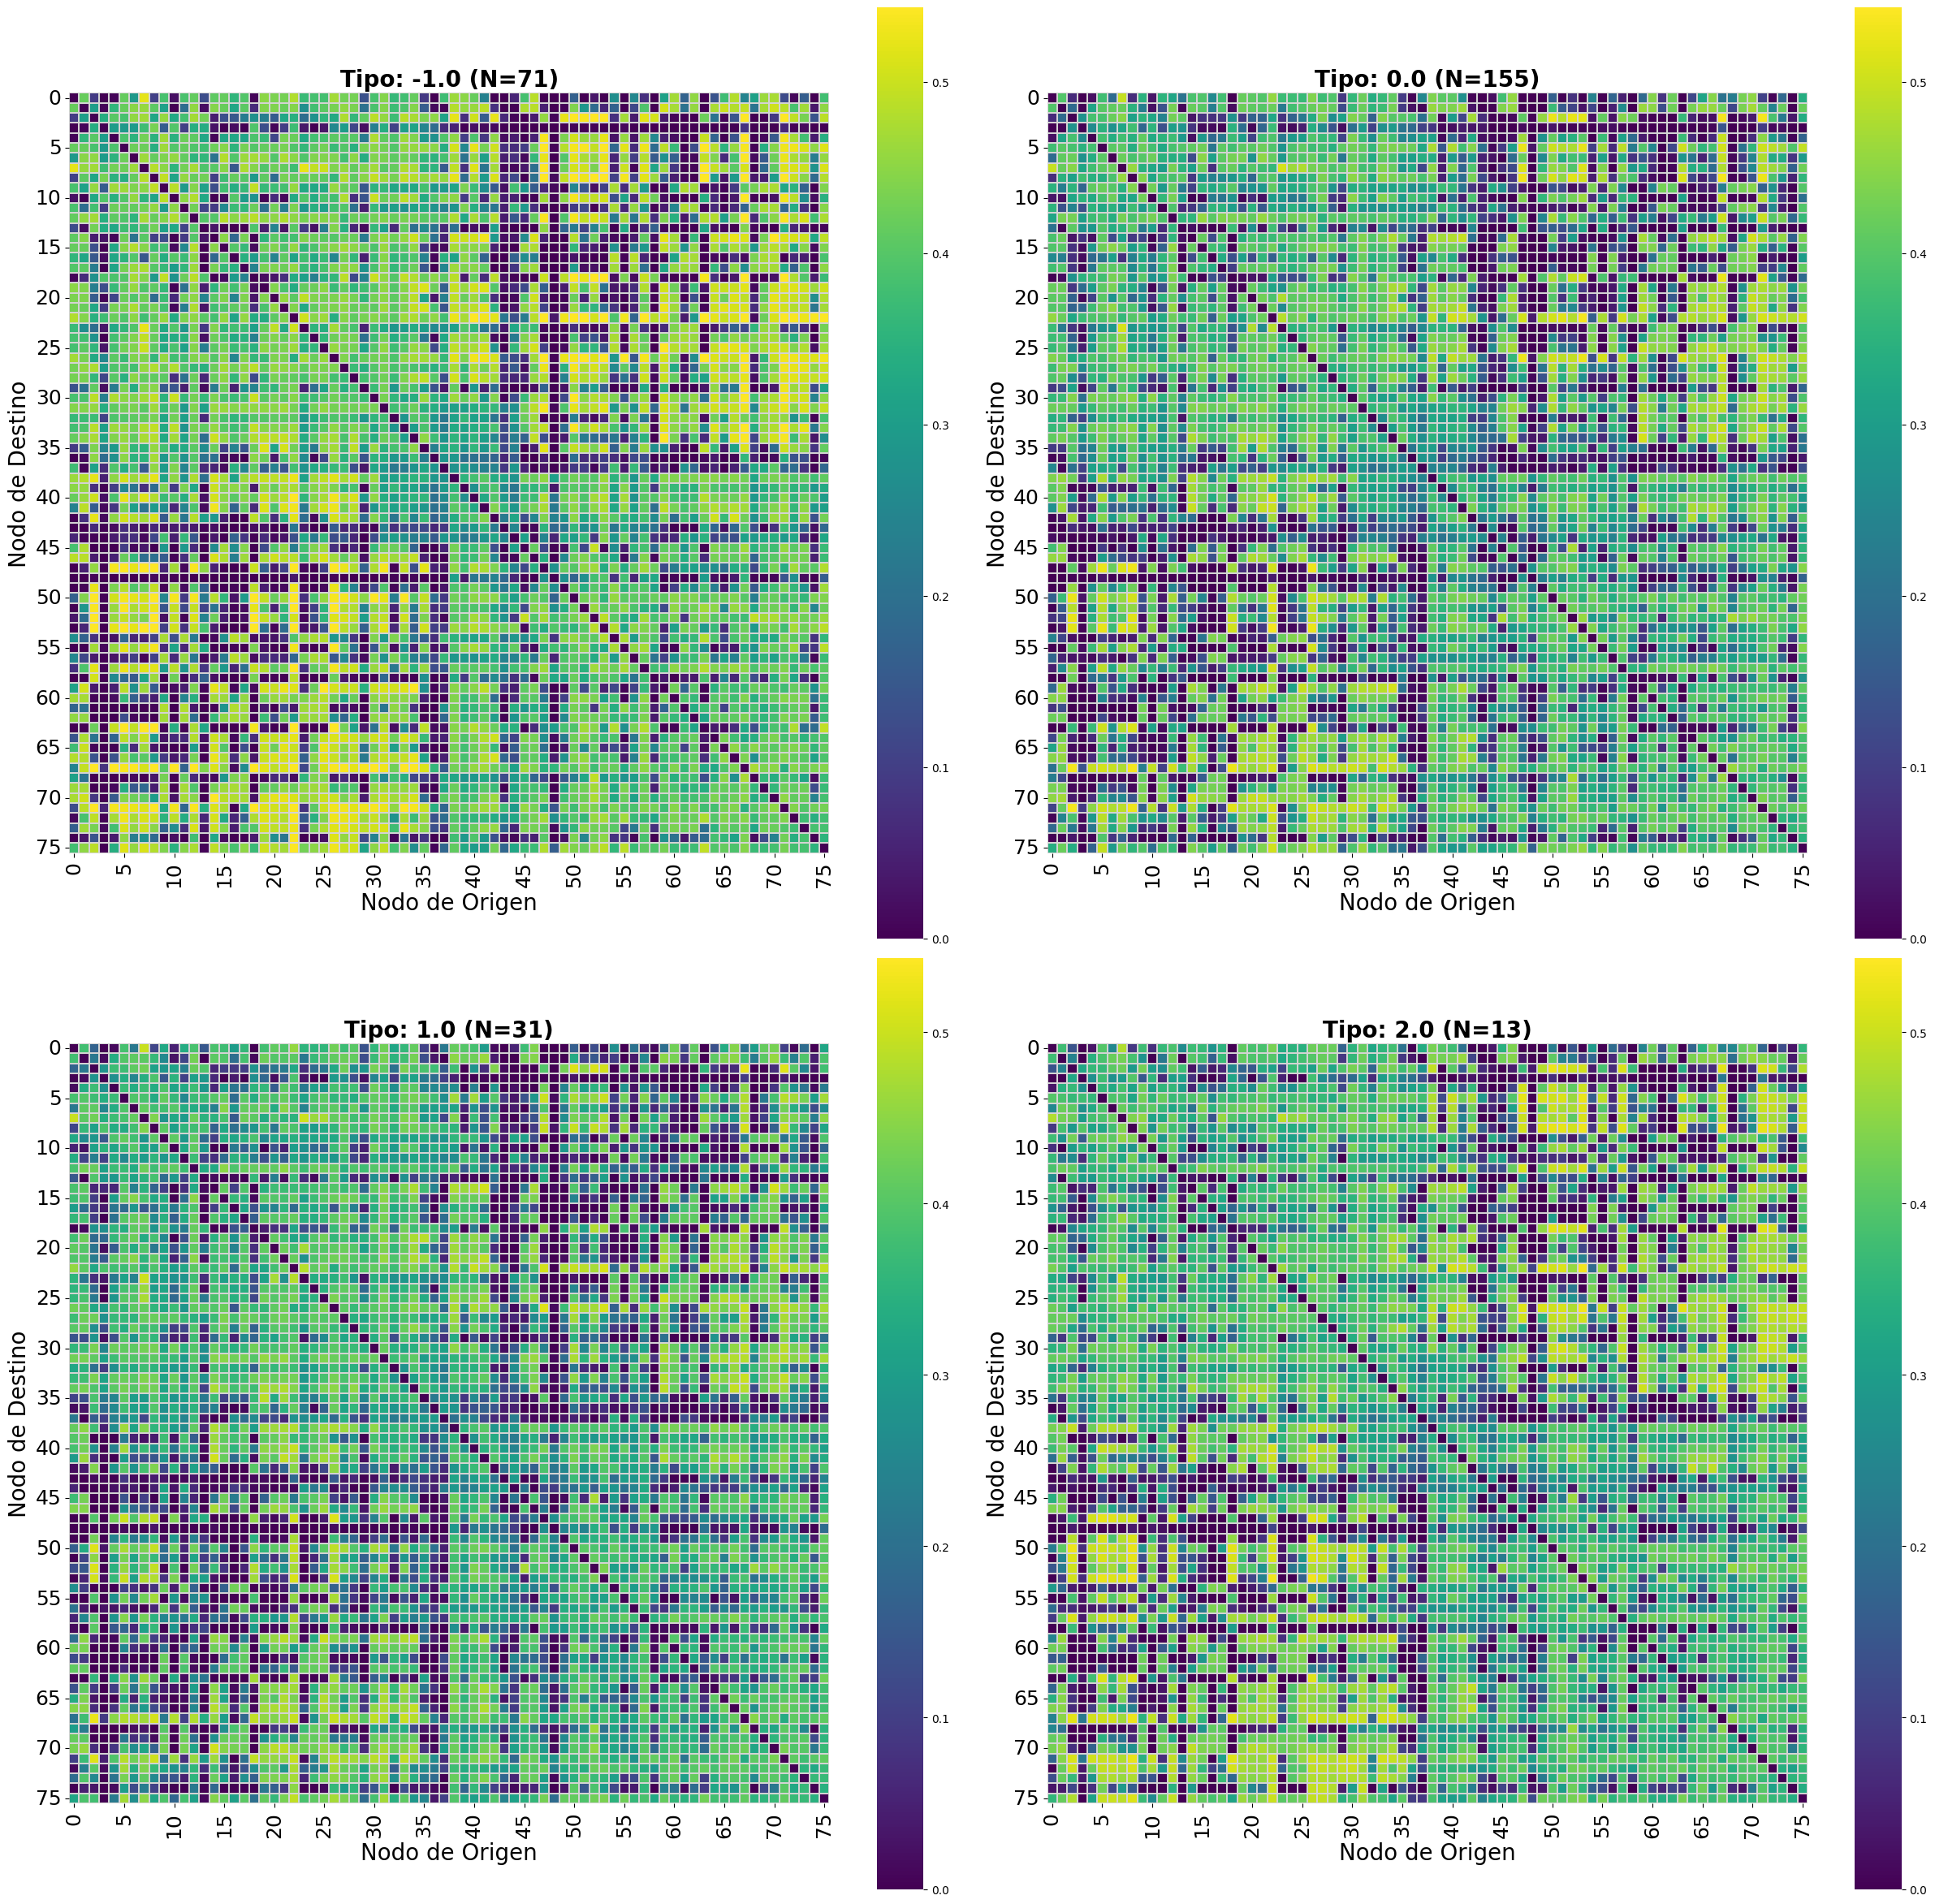

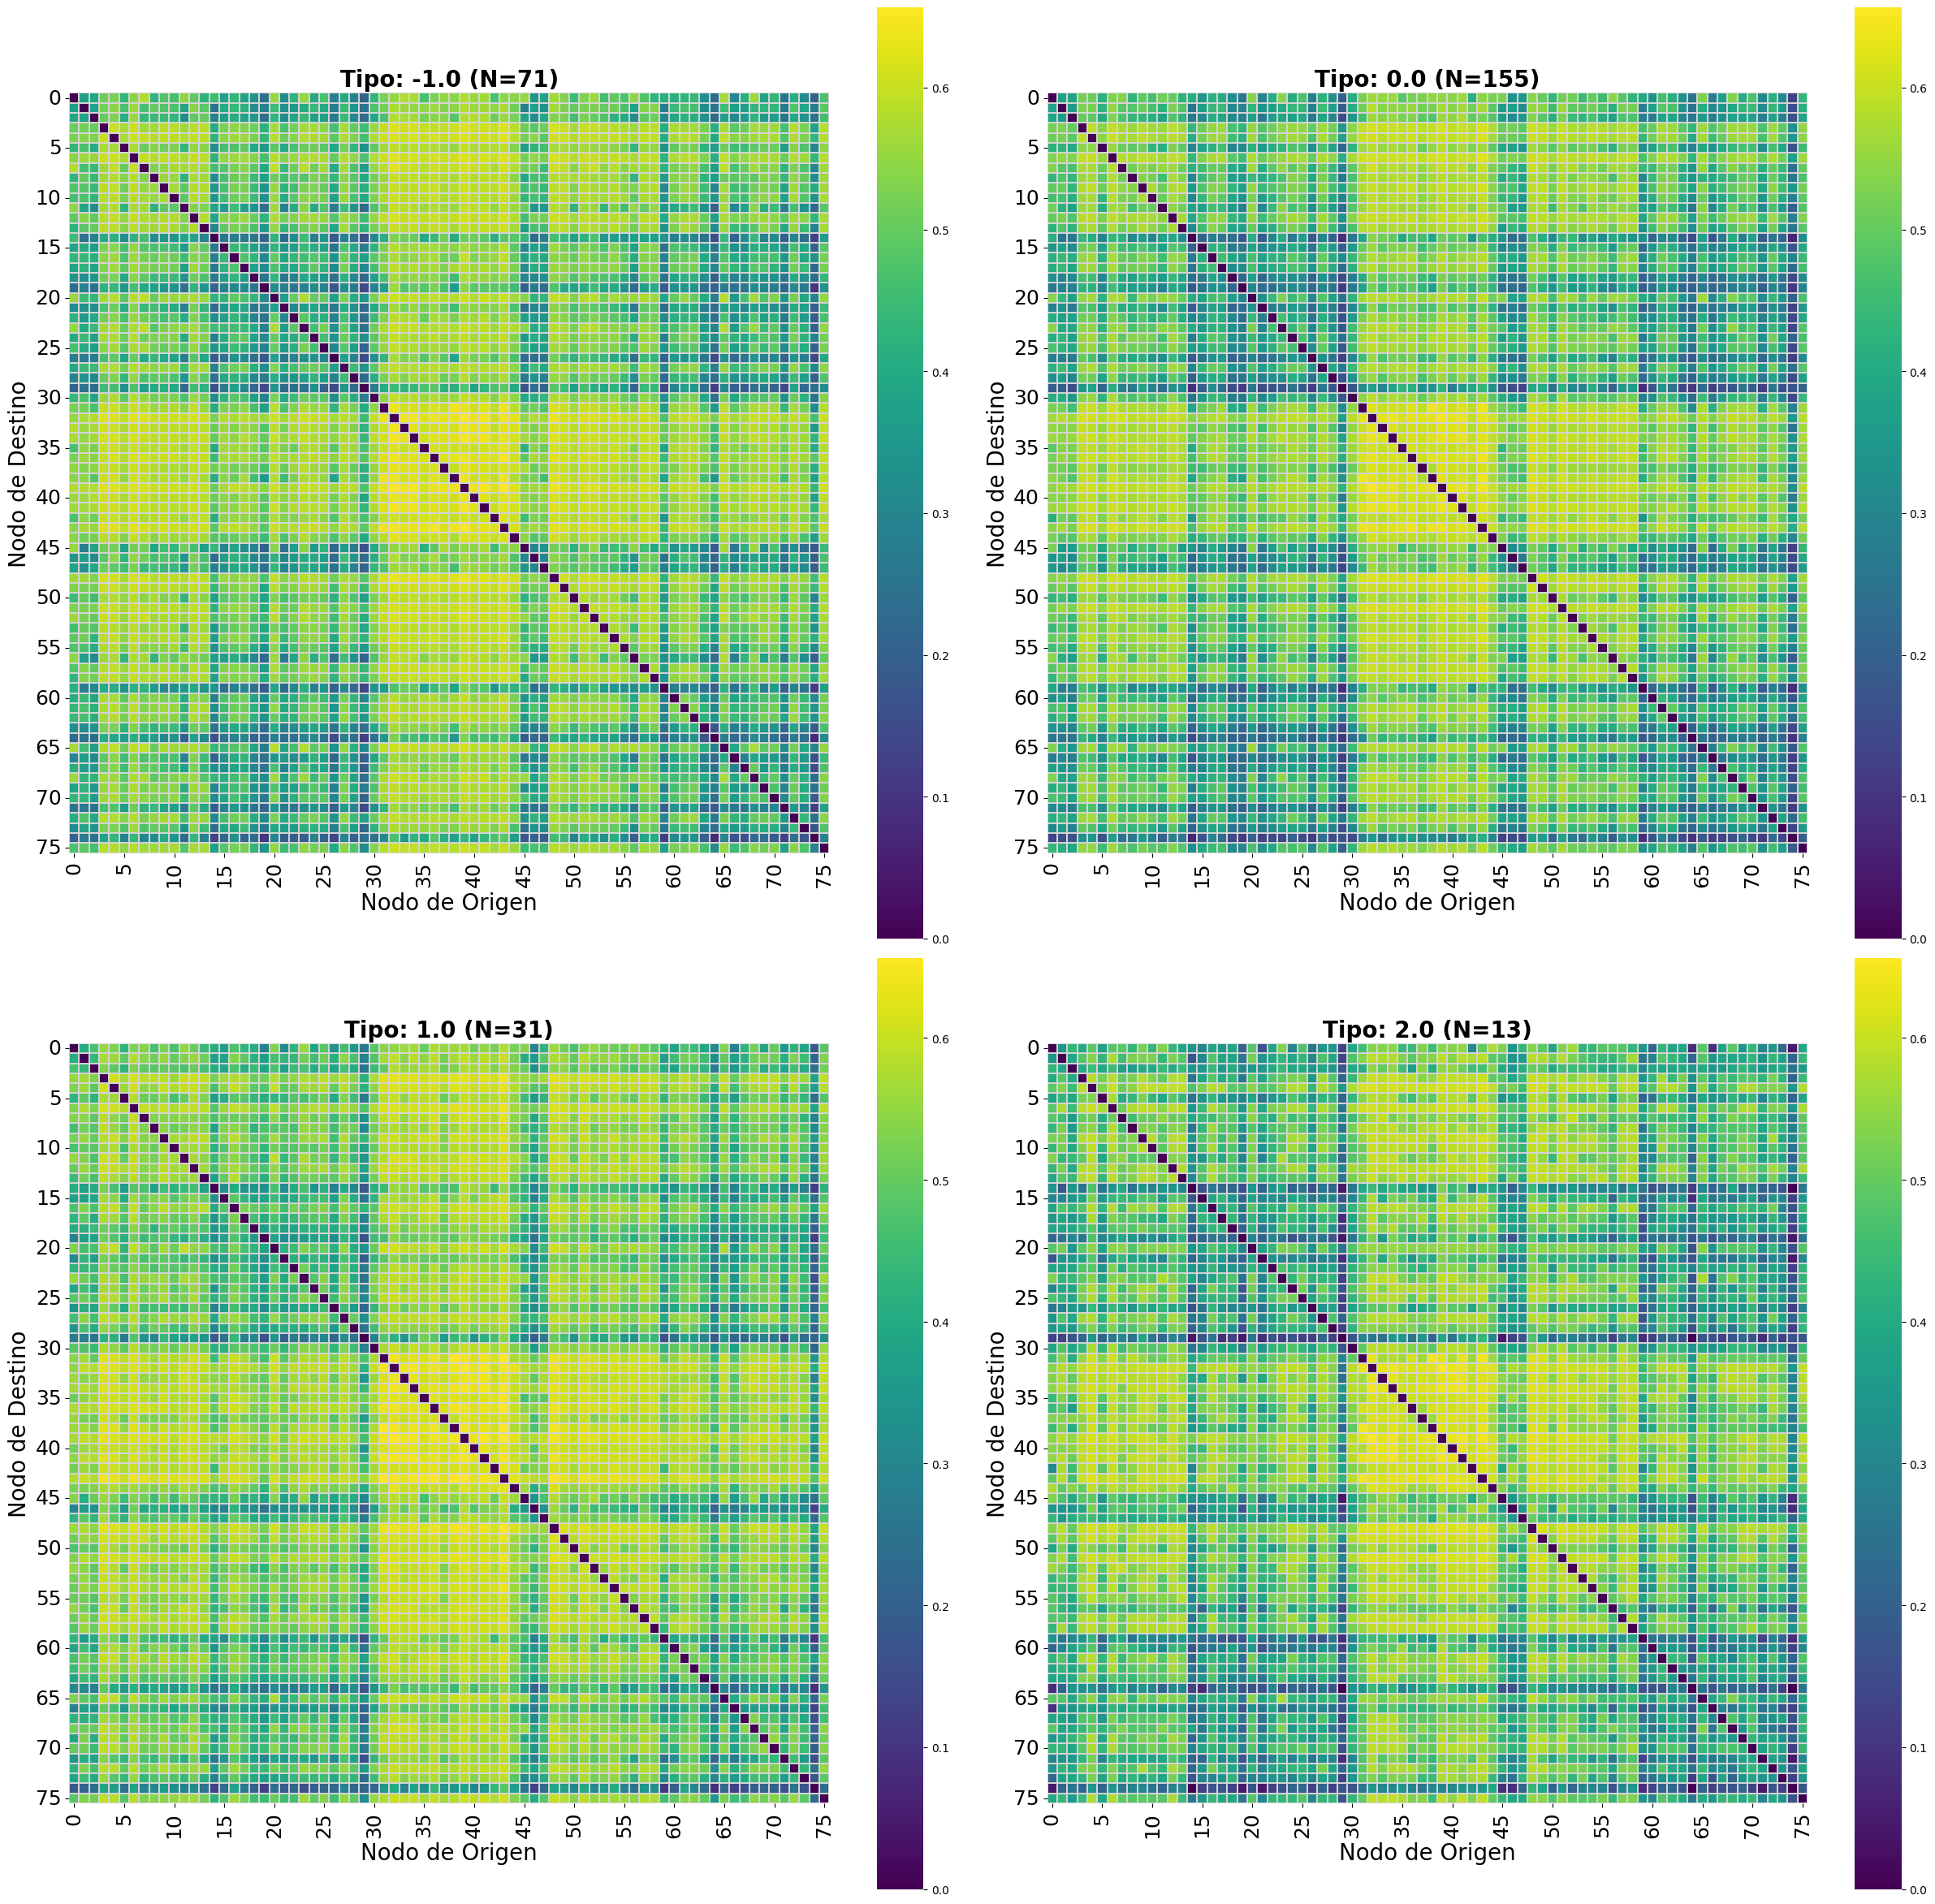

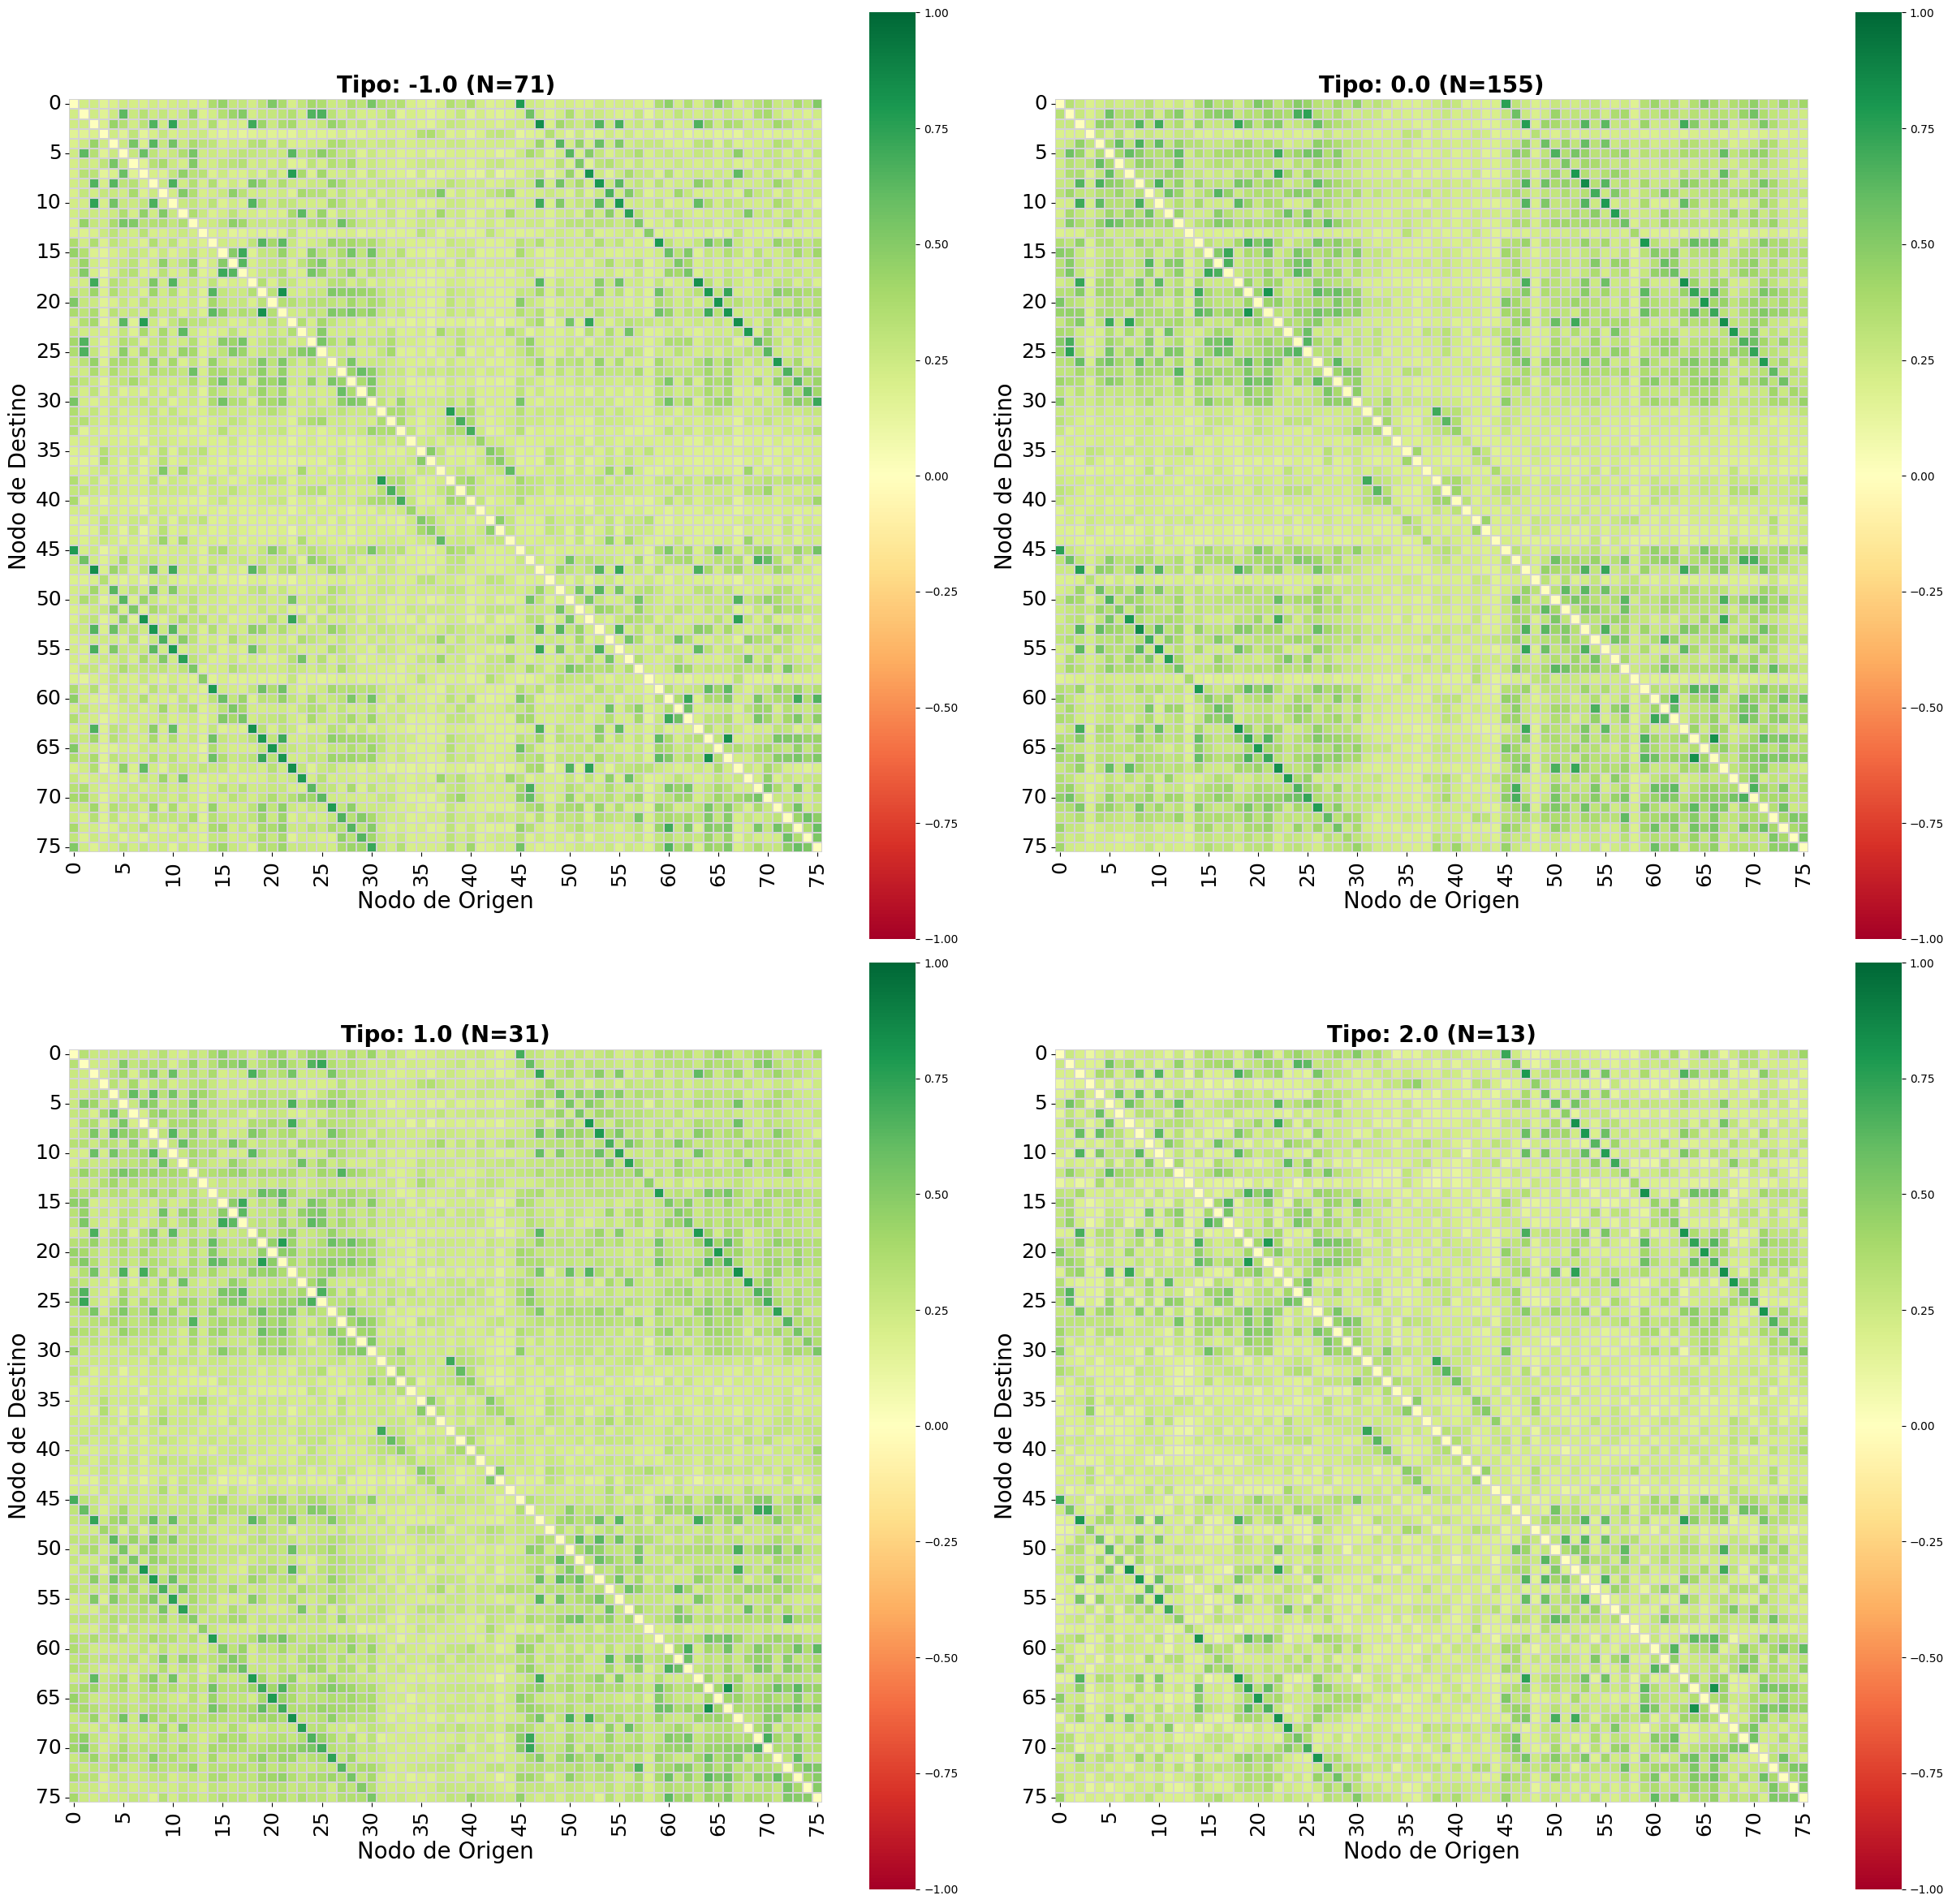

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any

def generar_heatmaps_por_mstype(
    tensor_conexiones: np.ndarray,
    mstypes: List[Any],
    usar_escala_divergente: bool = False, # Nuevo argumento para la escala de color
    max_heatmaps: int = 4, # Número máximo de heatmaps a mostrar
    n_labels_skip: int = 5 # Saltar etiquetas en los ejes para evitar superposición
):
    """
    Genera heatmaps mejorados para la matriz de adyacencia promedio de cada subtipo
    en un tensor de conexiones de pacientes, con escala de color condicional.

    Args:
        tensor_conexiones (np.ndarray): Tensor de forma (n_nodos, n_nodos, n_pacientes).
        mstypes (List[Any]): Lista de longitud n_pacientes con el tipo de esclerosis
                             de cada paciente.
        usar_escala_divergente (bool): Si es True, usa escala -1 a 1 (Rojo a Verde).
                                      Si es False, usa escala 0 a 1 (Viridis).
        max_heatmaps (int): Número máximo de heatmaps a generar (por ejemplo, 4 para 2x2).
        n_labels_skip (int): Número de etiquetas a saltar en los ejes (ej. 5 muestra cada 5ta etiqueta).
    """

    # 1. Adaptar el tensor para facilitar el indexing (n_pacientes, n_nodos, n_nodos)
    tensor_pacientes = np.transpose(tensor_conexiones, (2, 0, 1))
    n_nodos = tensor_conexiones.shape[0]

    # 2. Identificar los subtipos únicos
    tipos_unicos = np.unique(mstypes)

    # Filtrar para mostrar solo el número máximo solicitado
    tipos_a_mostrar = tipos_unicos[:max_heatmaps]
    n_plots = len(tipos_a_mostrar)

    if n_plots == 0:
        print("No hay tipos de esclerosis para mostrar.")
        return

    # 3. Determinar el tamaño dinámico de la figura (lógica de dimensionamiento omitida para brevedad, usando la tuya)
    base_size_per_node = 0.15
    figsize_x_single = n_nodos * base_size_per_node
    figsize_y_single = n_nodos * base_size_per_node

    if n_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=(figsize_x_single + 2, figsize_y_single + 2))
        axes = [axes]
    elif n_plots == 2:
        fig, axes = plt.subplots(1, 2, figsize=((figsize_x_single + 2) * 2, figsize_y_single + 2))
    elif n_plots == 3 or n_plots == 4:
        fig, axes = plt.subplots(2, 2, figsize=((figsize_x_single + 1) * 2, (figsize_y_single + 1) * 2))
        axes = axes.flatten()
    else:
        print(f"Número de heatmaps ({n_plots}) excede el límite de {max_heatmaps}. Considera ajustar 'max_heatmaps'.")
        return

    # 3.5 Definir la escala de color y el rango
    if usar_escala_divergente:
        # Escala divergente: Rojo (-1) -> Blanco (0) -> Verde (1)
        # Usamos 'RdYlGn' o 'coolwarm' centrado. RdYlGn es más común para Rojo-Verde.
        mapa_color = "RdYlGn"
        v_min_global = -1.0
        v_max_global = 1.0
    else:
        # Escala secuencial: Viridis (0) -> Viridis (1)
        mapa_color = "viridis"
        media_global_tensor = np.mean(tensor_pacientes, axis=0)
        v_min_global = np.min(media_global_tensor)
        v_max_global = np.max(media_global_tensor)

    # 4. Iterar sobre los subtipos, calcular la media y generar el heatmap
    mstypes_np = np.array(mstypes)

    for i, mstype in enumerate(tipos_a_mostrar):
        ax = axes[i]

        indices_pacientes = np.where(mstypes_np == mstype)[0]
        matrices_subtipo = tensor_pacientes[indices_pacientes, :, :]
        media_subtipo = np.mean(matrices_subtipo, axis=0)

        # Generar el Heatmap con mejoras
        # Se usan las variables de escala definidas condicionalmente
        sns.heatmap(
            media_subtipo,
            ax=ax,
            cmap=mapa_color,
            cbar=True,
            square=True,
            vmin=v_min_global,
            vmax=v_max_global,
            linewidths=0.01,
            linecolor='lightgray'
        )

        # Mejorar etiquetas de ejes (lógica omitida para brevedad, usando la tuya)
        ax.set_xlabel('Nodo de Origen', fontsize=20)
        ax.set_ylabel('Nodo de Destino', fontsize=20)

        # Etiquetas de los ticks
        tick_labels = np.arange(0, n_nodos, n_labels_skip)
        ax.set_xticks(tick_labels + 0.5)
        ax.set_yticks(tick_labels + 0.5)
        ax.set_xticklabels(tick_labels, rotation=90, ha='center', fontsize=18)
        ax.set_yticklabels(tick_labels, rotation=0, va='center', fontsize=18)

        # Asegurarse de que los límites de los ejes estén correctos
        ax.set_xlim(0, n_nodos)
        ax.set_ylim(n_nodos, 0)

        # Formatear el título del subplot
        if isinstance(mstype, (int, float)):
            titulo_mstype = f'{mstype:.1f}'
        else:
            titulo_mstype = str(mstype)

        ax.set_title(f'Tipo: {titulo_mstype} (N={len(indices_pacientes)})', fontsize=20, fontweight='bold')

    # 5. Ajustar el layout y mostrar el gráfico
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()



# Llamar a la función
generar_heatmaps_por_mstype(FA_matrices_tensor, mstypes)
generar_heatmaps_por_mstype(GM_matrices_tensor, mstypes)
generar_heatmaps_por_mstype(rsfMRI_matrices_tensor, mstypes, True)

In [ ]:
def aplanar_triangulo_superior(tensor, anuladas=None):
    """
    Aplana el triángulo superior (sin la diagonal) de un tensor de matrices.

    Parámetros:
    - tensor: array (N, N, ...) donde tensor[i, j] es una lista o vector.
    - anuladas: matriz booleana (N, N) donde True indica conexión anulada (opcional).

    Devuelve:
    - np.array con los valores concatenados de las posiciones (i, j) no anuladas.
    """
    valores = []
    filas = len(tensor)
    columnas = len(tensor[0])

    for i in range(filas):
        for j in range(i + 1, columnas):
            if anuladas is not None and anuladas[i, j]:
                # Si está anulada, se salta
                continue
            valores.extend(tensor[i, j])

    return np.array(valores)

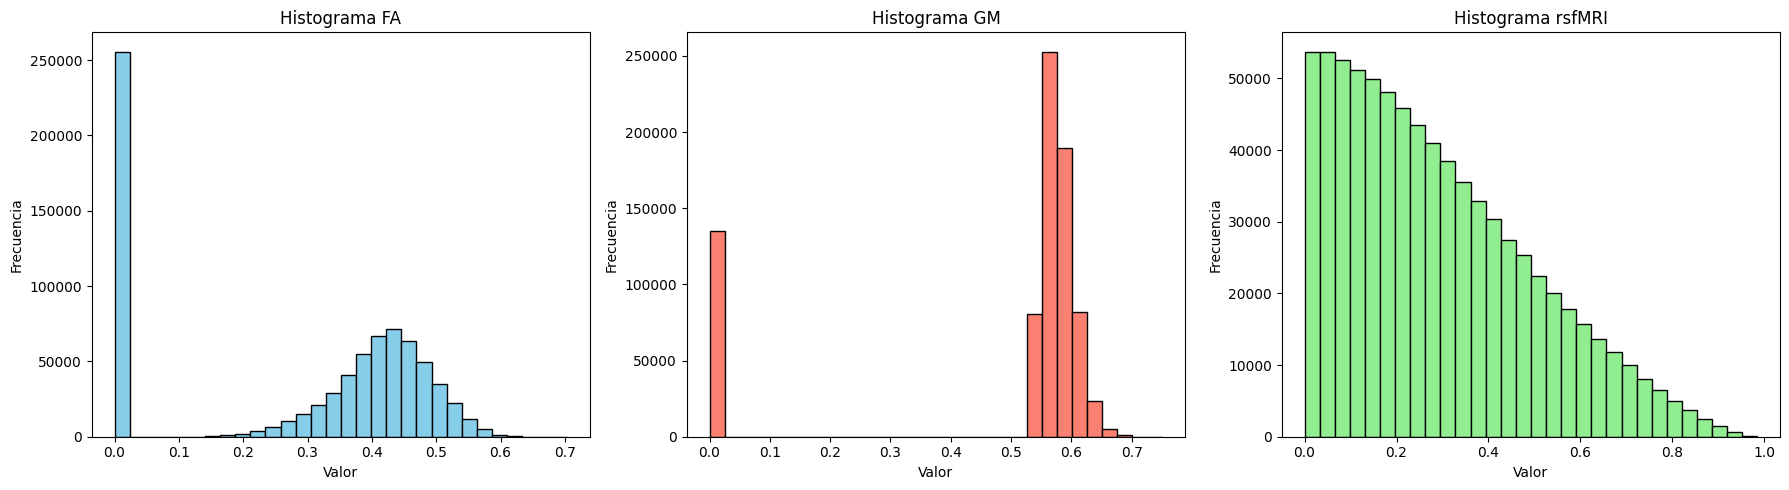

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

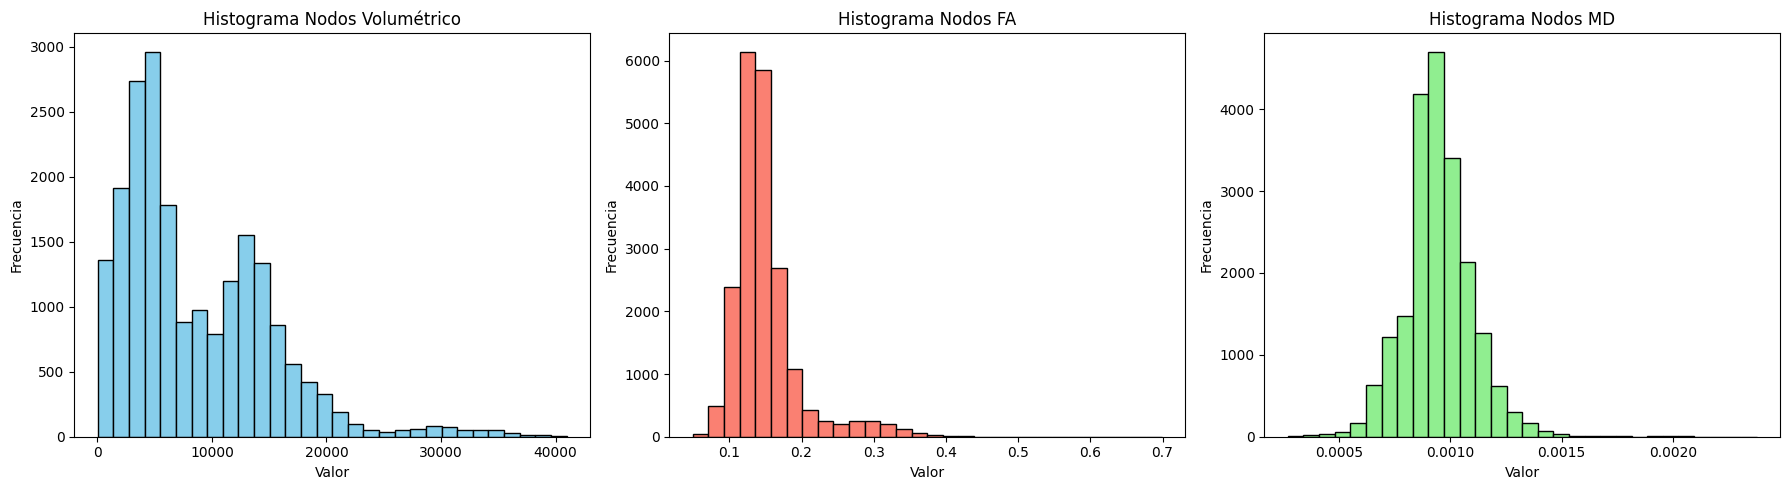

In [ ]:
# Aplanar todos los valores de nodos_volumetricos
valores_nodos_volumetricos = [valor for nodo in nodos_volumetricos_tensor for valor in nodo]
valores_nodos_volumetricos = np.array(valores_nodos_volumetricos)

# Aplanar todos los valores de nodos_FA
valores_nodos_FA = [valor for nodo in nodos_FA_tensor for valor in nodo]
valores_nodos_FA = np.array(valores_nodos_FA)

# Aplanar todos los valores de nodos_MD
valores_nodos_MD = [valor for nodo in nodos_MD_tensor for valor in nodo]
valores_nodos_MD = np.array(valores_nodos_MD)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_nodos_volumetricos, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma Nodos Volumétrico')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_nodos_FA, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma Nodos FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_nodos_MD, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma Nodos MD')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# rsfMRI corregir signos a abs

In [ ]:
rsfMRI_matrices_tensor = np.abs(rsfMRI_matrices_tensor)

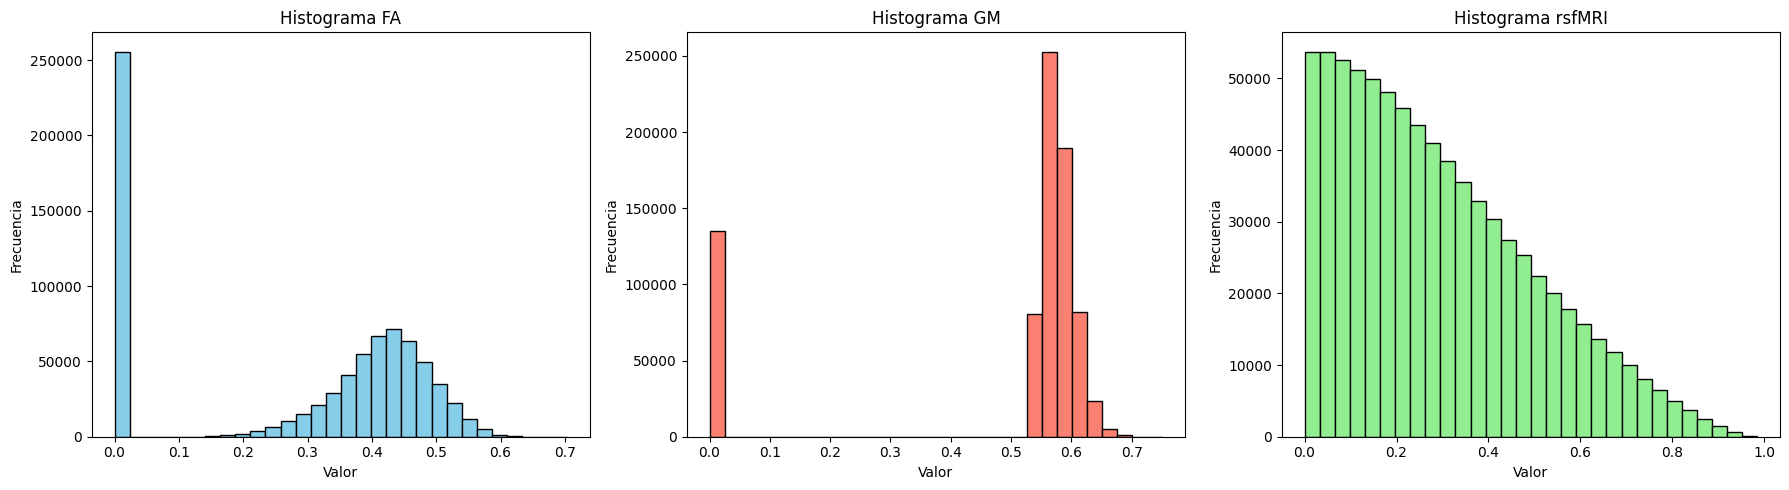

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Eliminar conexiones espuria y almacenar 0's

In [ ]:
def anular_conexiones_inestables(tensor, control_mses, umbral_cero=0.6, umbral_eliminar=0.1):
    """
    Paso 1: Anula (pone a 0) las conexiones completas si el porcentaje de valores
    cercanos a cero en el grupo de control supera el umbral.
    """
    tensor_out = tensor.copy()

    # 1. Seleccionamos solo las muestras de control (control_mses == 0)
    # Esto crea una vista temporal de forma (i, j, n_controles)
    mask_control = (control_mses == 0)
    tensor_control = tensor_out[:, :, mask_control]

    # Si no hay controles, no se anula nada
    if tensor_control.shape[2] == 0:
        conexiones_anuladas = np.zeros(tensor.shape[:2], dtype=bool)
        return tensor_out, conexiones_anuladas

    # 2. Calculamos el porcentaje de valores bajos a lo largo del eje de las muestras (axis=2)
    # Esto devuelve una matriz (i, j) con los porcentajes
    porcentaje_bajos = np.mean(tensor_control <= umbral_eliminar, axis=2)

    # 3. Generamos la máscara de conexiones a anular
    conexiones_anuladas = porcentaje_bajos >= umbral_cero

    # 4. Aplicamos la anulación: Donde la máscara es True, todas las muestras pasan a 0
    tensor_out[conexiones_anuladas, :] = 0.0

    return tensor_out, conexiones_anuladas

In [ ]:
def convertir_bajos_a_nan(tensor, conexiones_anuladas, umbral_eliminar=0.1):
    """
    Paso 2: Convierte a NaN los valores <= umbral_eliminar,
    EXCEPTO en aquellas conexiones que fueron explícitamente anuladas.

    Returns:
        tuple: (tensor_con_nans, mask_nans)
            - tensor_con_nans: El tensor con los valores bajos convertidos a NaN.
            - mask_nans: Matriz booleana (i, j, muestras) con True donde se puso un NaN.
    """
    tensor_out = tensor.copy()

    # 1. Identificamos todos los valores que son "bajos" (incluyendo los 0s)
    # Nota: Las comparaciones con NaN siempre dan False, así que no afecta si ya había NaNs.
    mask_valores_bajos = tensor_out <= umbral_eliminar

    # 2. Protegemos las conexiones anuladas.
    # La máscara 'conexiones_anuladas' es (i, j). Usamos np.newaxis para broadcasting con (i, j, muestras).
    mask_protegida = ~conexiones_anuladas[:, :, np.newaxis]

    # 3. Combinamos: Debe ser un valor bajo Y NO estar en una conexión anulada
    mask_final_nan = mask_valores_bajos & mask_protegida

    # 4. Aplicamos NaN usando la máscara combinada
    tensor_out[mask_final_nan] = np.nan

    # Devolvemos el tensor y la máscara de lo que acabamos de convertir
    return tensor_out, mask_final_nan

In [ ]:
# Anular conexiones que tienen 60% en pacientes sanos con valor inferior a 0.1
FA_matrices_tensor, FA_null_conections = anular_conexiones_inestables(FA_matrices_tensor, controls_mses)
GM_matrices_tensor, GM_null_conections = anular_conexiones_inestables(GM_matrices_tensor, controls_mses)
rsfMRI_matrices_tensor, rsfMRI_null_conections = anular_conexiones_inestables(rsfMRI_matrices_tensor, controls_mses)

# Almacenar las conexiones que inferiores a 0.1 que no hayan sido anuladas
_, FA_nan_mask = convertir_bajos_a_nan(FA_matrices_tensor, FA_null_conections)
_, GM_nan_mask = convertir_bajos_a_nan(GM_matrices_tensor, GM_null_conections)
_, rsfMRI_nan_mask = convertir_bajos_a_nan(rsfMRI_matrices_tensor, rsfMRI_null_conections)

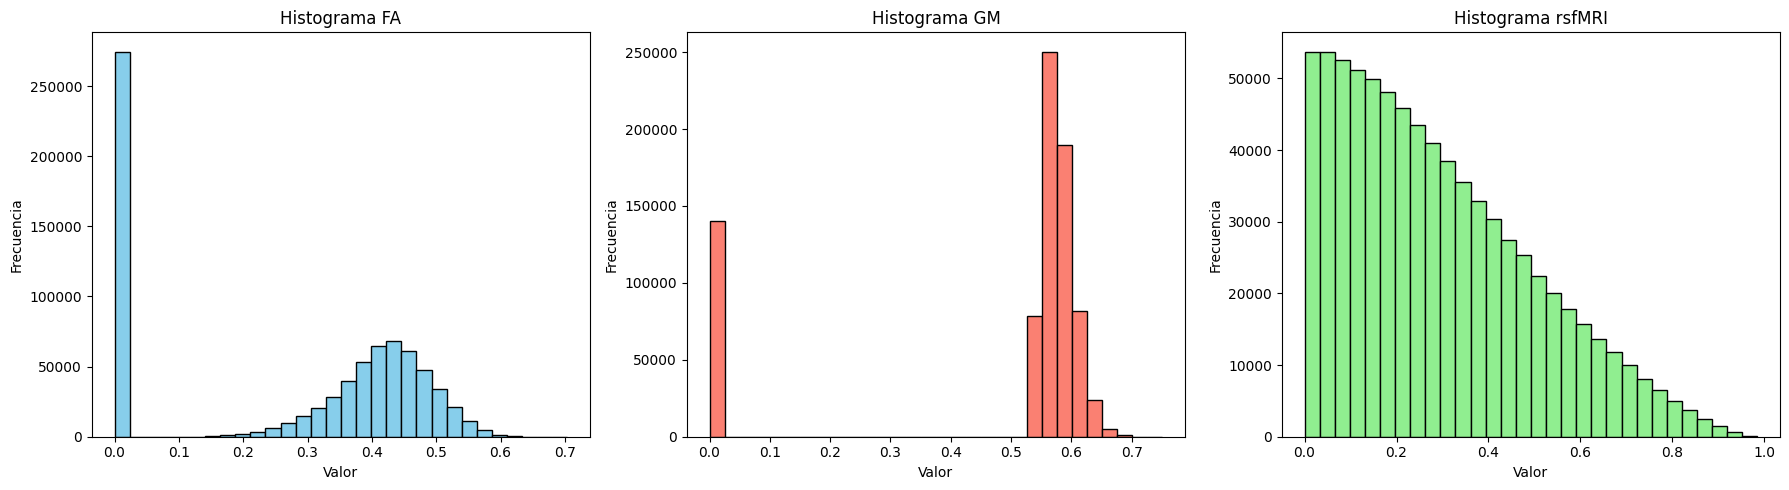

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Sin las conexiones anuladas.

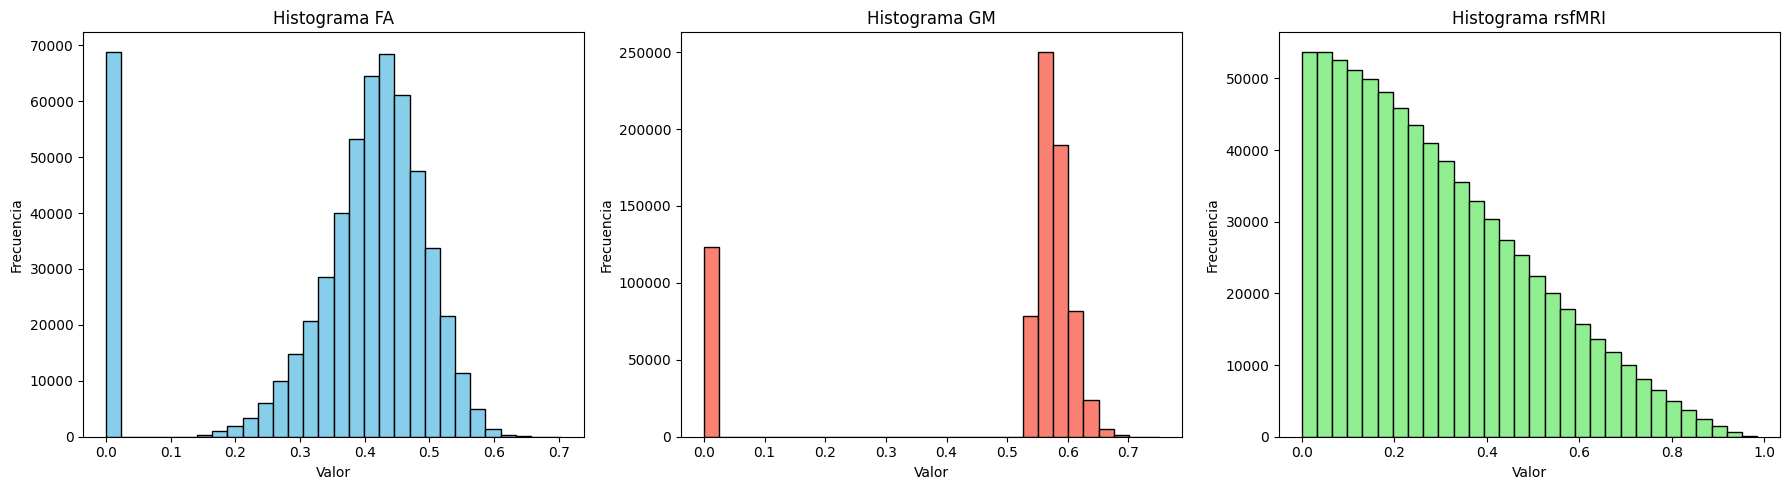

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor, rsfMRI_null_conections)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Corregir sexo y edad

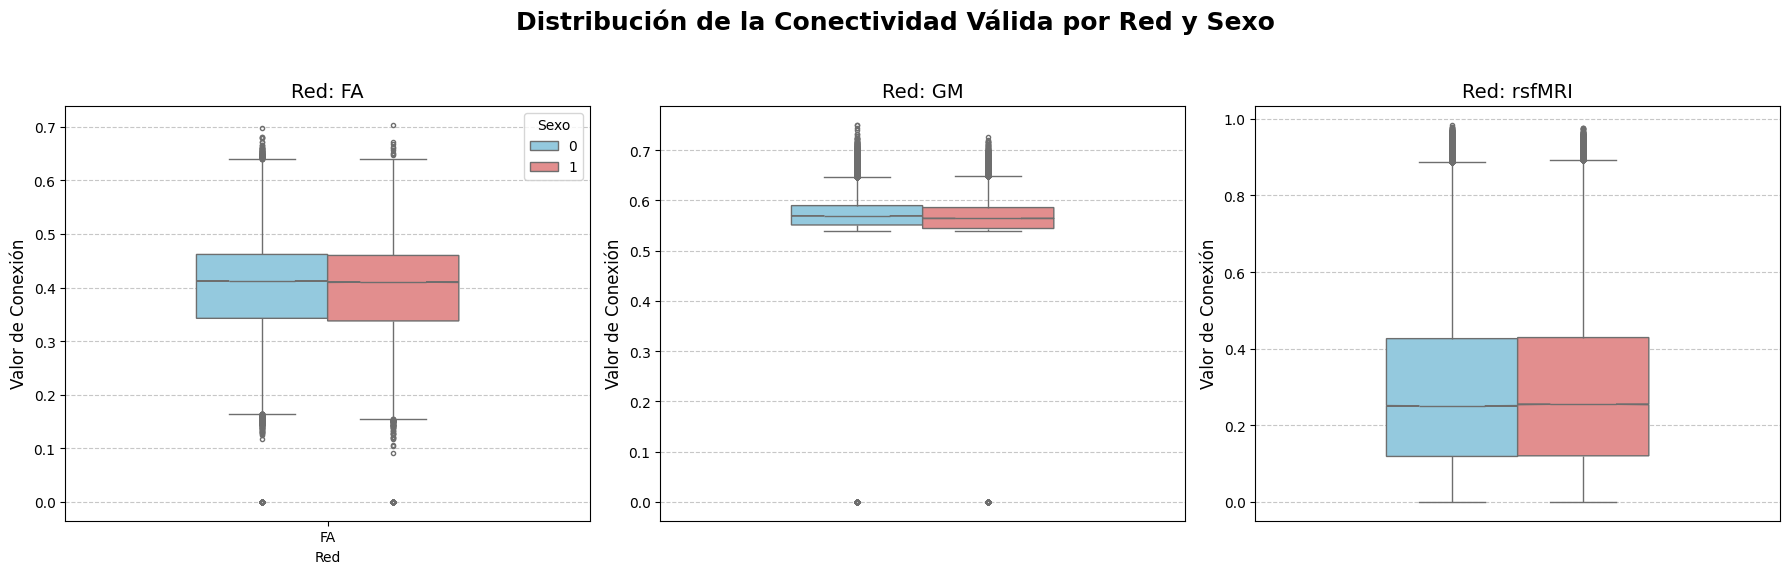

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any

# Mantenemos la función auxiliar para el filtrado, ya que es correcta.
def obtener_triangulo_superior_derecho_filtrado(
    tensor_conexiones: np.ndarray,
    mascara_anulada: np.ndarray
) -> np.ndarray:
    """
    Extrae los valores válidos del TSR para cada paciente.
    """
    n_nodos = tensor_conexiones.shape[0]
    n_pacientes = tensor_conexiones.shape[2]

    mascara_tsr = np.triu(np.ones((n_nodos, n_nodos), dtype=bool), k=1)
    mascara_final = mascara_tsr & (~mascara_anulada)
    indices_validos = np.where(mascara_final)
    n_conexiones_validas = len(indices_validos[0])

    valores_filtrados = np.empty((n_pacientes, n_conexiones_validas))

    for i in range(n_pacientes):
        valores_filtrados[i, :] = tensor_conexiones[:, :, i][indices_validos]

    return valores_filtrados

def generar_boxplots_separados_por_red_y_sexo(
    tensor_FA: np.ndarray,
    tensor_GM: np.ndarray,
    tensor_rsfMRI: np.ndarray,
    mascara_anulada_FA: np.ndarray,
    mascara_anulada_GM: np.ndarray,
    mascara_anulada_rsfMRI: np.ndarray,
    sex_pacientes: List[str]
):
    """
    Genera boxplots separados (con escala Y propia) para cada tipo de red,
    mostrando la distribución de la conectividad por sexo.
    """

    # 1. Extraer y filtrar los valores
    valores_filtrados_FA = obtener_triangulo_superior_derecho_filtrado(tensor_FA, mascara_anulada_FA)
    valores_filtrados_GM = obtener_triangulo_superior_derecho_filtrado(tensor_GM, mascara_anulada_GM)
    valores_filtrados_rsfMRI = obtener_triangulo_superior_derecho_filtrado(tensor_rsfMRI, mascara_anulada_rsfMRI)

    # 2. Preparar los DataFrames individuales para cada red
    n_pacientes = len(sex_pacientes)

    # Función auxiliar para crear el DataFrame de una sola red
    def crear_df_red(valores_filtrados: np.ndarray, nombre_red: str, sex_pacientes: List[str]) -> pd.DataFrame:
        n_conexiones_validas = valores_filtrados.shape[1]

        # Crear la lista de sexos repetida por el número de conexiones válidas por paciente
        labels_sexo = []
        for i in range(n_pacientes):
            labels_sexo.extend([sex_pacientes[i]] * n_conexiones_validas)

        df = pd.DataFrame({
            'Valor': valores_filtrados.flatten(),
            'Red': nombre_red,
            'Sexo': labels_sexo
        })
        return df

    df_FA = crear_df_red(valores_filtrados_FA, 'FA', sex_pacientes)
    df_GM = crear_df_red(valores_filtrados_GM, 'GM', sex_pacientes)
    df_rsfMRI = crear_df_red(valores_filtrados_rsfMRI, 'rsfMRI', sex_pacientes)

    dataframes_red = {
        'FA': df_FA,
        'GM': df_GM,
        'rsfMRI': df_rsfMRI
    }

    # 3. Generar los boxplots en subplots separados (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=False) # sharey=False es clave

    redes = ['FA', 'GM', 'rsfMRI']

    fig.suptitle('Distribución de la Conectividad Válida por Red y Sexo', fontsize=18, fontweight='bold')

    for i, red in enumerate(redes):
        df_actual = dataframes_red[red]
        ax = axes[i]

        # Generar el boxplot
        sns.boxplot(
            x='Red',
            y='Valor',
            hue='Sexo',
            data=df_actual,
            ax=ax,
            palette=['skyblue', 'lightcoral'],
            fliersize=3,
            notch=True,
            width=0.5 # Ancho para que los boxplots se vean más juntos
        )

        # Ajustes estéticos por subplot
        ax.set_title(f'Red: {red}', fontsize=14)
        ax.set_ylabel('Valor de Conexión', fontsize=12)
        ax.tick_params(axis='x', labelrotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Ocultar la leyenda y la etiqueta X si no es el primer gráfico o si es redundante
        if i > 0:
            ax.get_legend().remove()
            ax.set_xlabel('')
            # En este caso, solo hay un valor en el eje X ('FA', 'GM' o 'rsfMRI'),
            # por lo que el título del eje X no es necesario.
            ax.set_xticks([]) # Quita los ticks del eje X
        else:
             # Solo el primer gráfico tiene la leyenda completa
            ax.legend(title='Sexo', loc='upper right')
            ax.set_xticks([0]) # Mantén solo el centro para el nombre de la red
            ax.set_xticklabels([red]) # Usa el nombre de la red como etiqueta X

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el suptitle
    plt.show()




# Llamar a la función modificada
generar_boxplots_separados_por_red_y_sexo(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    sexes
)

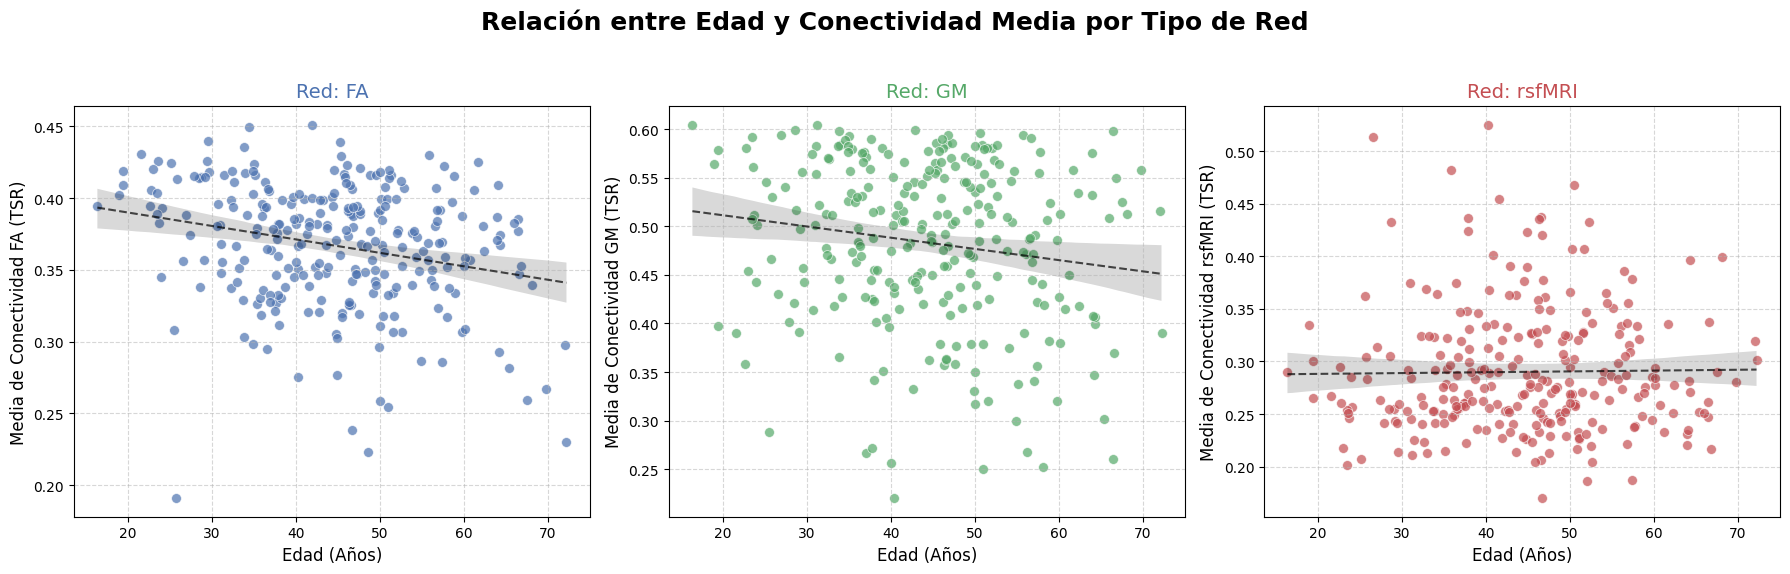

In [ ]:
def generar_dispersion_por_red_y_edad(
    tensor_FA: np.ndarray,
    tensor_GM: np.ndarray,
    tensor_rsfMRI: np.ndarray,
    mascara_anulada_FA: np.ndarray,
    mascara_anulada_GM: np.ndarray,
    mascara_anulada_rsfMRI: np.ndarray,
    age_pacientes: List[float] # Ahora es una lista de valores continuos (edad)
):
    """
    Genera gráficos de dispersión separados para cada tipo de red, mostrando la
    media de conectividad (TSR filtrado) versus la edad de los pacientes.
    """

    # 1. Extraer y filtrar los valores
    valores_filtrados_FA = obtener_triangulo_superior_derecho_filtrado(tensor_FA, mascara_anulada_FA)
    valores_filtrados_GM = obtener_triangulo_superior_derecho_filtrado(tensor_GM, mascara_anulada_GM)
    valores_filtrados_rsfMRI = obtener_triangulo_superior_derecho_filtrado(tensor_rsfMRI, mascara_anulada_rsfMRI)

    # 2. Calcular la MEDIA de las conexiones válidas para CADA paciente
    # El resultado será un array de (n_pacientes,)
    media_FA = np.mean(valores_filtrados_FA, axis=1)
    media_GM = np.mean(valores_filtrados_GM, axis=1)
    media_rsfMRI = np.mean(valores_filtrados_rsfMRI, axis=1)

    # 3. Preparar los DataFrames individuales para cada red
    df_data = pd.DataFrame({
        'Edad': age_pacientes,
        'Media_Conectividad_FA': media_FA,
        'Media_Conectividad_GM': media_GM,
        'Media_Conectividad_rsfMRI': media_rsfMRI,
    })

    # 4. Generar los gráficos de dispersión en subplots separados
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=False) # sharex=True para escala de edad común

    redes = ['FA', 'GM', 'rsfMRI']
    columnas_media = ['Media_Conectividad_FA', 'Media_Conectividad_GM', 'Media_Conectividad_rsfMRI']
    colores = ['#4C72B0', '#55A868', '#C44E52'] # Paleta de colores para las redes

    fig.suptitle('Relación entre Edad y Conectividad Media por Tipo de Red', fontsize=18, fontweight='bold')

    for i, red in enumerate(redes):
        col_y = columnas_media[i]
        color = colores[i]
        ax = axes[i]

        # Generar el gráfico de dispersión
        sns.scatterplot(
            x='Edad',
            y=col_y,
            data=df_data,
            ax=ax,
            color=color,
            s=50, # Tamaño de los puntos
            alpha=0.7 # Transparencia para ver superposición
        )

        # Opcional: Añadir línea de regresión para visualizar la tendencia
        # Seaborn puede añadir una línea de regresión lineal (lmplot) en un solo paso,
        # pero es más limpio usar scatterplot + regplot en el mismo eje para subplots.
        sns.regplot(
            x='Edad',
            y=col_y,
            data=df_data,
            ax=ax,
            scatter=False, # No dibuja los puntos, solo la línea de tendencia
            color='black',
            line_kws={'linestyle': '--', 'linewidth': 1.5, 'alpha': 0.7}
        )

        # Ajustes estéticos por subplot
        ax.set_title(f'Red: {red}', fontsize=14, color=color)
        ax.set_xlabel('Edad (Años)', fontsize=12)
        ax.set_ylabel(f'Media de Conectividad {red} (TSR)', fontsize=12)
        ax.grid(axis='both', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

generar_dispersion_por_red_y_edad(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    ages
)

In [ ]:
def harmonize_tensor_data_regression(tensor_data, variables, null_conections):
    """
    Vectoriza las conexiones (triángulo superior) de un tensor 3D,
    aplica regresión lineal para quitar el efecto de las covariables,
    y reconstruye el tensor corregido (residuos) sin usar squareform.

    Args:
        tensor_data (np.ndarray): Tensor de conectividad (R, R, N_pacientes).
        variables (pd.DataFrame): DataFrame con las variables clínicas (predictoras).
        null_conections (np.ndarray): Matriz booleana (R, R) con True donde la conexión fue completamente anulada.

    Returns:
        np.ndarray: Tensor 3D corregido por el efecto de las variables (residuos de regresión).
    """
    R, _, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # 1. Vectorización: Crear la matriz de Features x Pacientes
    features_list = []
    indices_list = []

    for i in range(R):
        for j in range(i+1, R):
            if not null_conections[i, j]:
                features_list.append(tensor_data[i, j, :])
                indices_list.append((i, j))

    # Matriz de entrada para regresión: [N_conexiones x N_pacientes]
    dat = np.array(features_list)

    # 2. Aplicar regresión lineal y calcular residuos
    corrected_tensor = np.zeros_like(tensor_data)  # diagonal nula por inicialización

    model = LinearRegression()

    for k, (i, j) in enumerate(indices_list):
        y = dat[k, :]
        model.fit(variables.values, y)
        y_pred = model.predict(variables.values)
        residuals = y - y_pred
        corrected_tensor[i, j, :] = residuals
        corrected_tensor[j, i, :] = residuals  # simetría

    # Conexiones nulas se conservan igual que en el tensor original
    for i in range(R):
        for j in range(i+1, R):
            if null_conections[i, j]:
                corrected_tensor[i, j, :] = tensor_data[i, j, :]
                corrected_tensor[j, i, :] = tensor_data[i, j, :]

    return corrected_tensor

In [ ]:
variables = pd.DataFrame({"age":ages,
                          "sex":sexes})

FA_matrices_tensor = harmonize_tensor_data_regression(FA_matrices_tensor, variables, FA_null_conections)
GM_matrices_tensor = harmonize_tensor_data_regression(GM_matrices_tensor, variables, GM_null_conections)
rsfMRI_matrices_tensor = harmonize_tensor_data_regression(rsfMRI_matrices_tensor, variables, rsfMRI_null_conections)

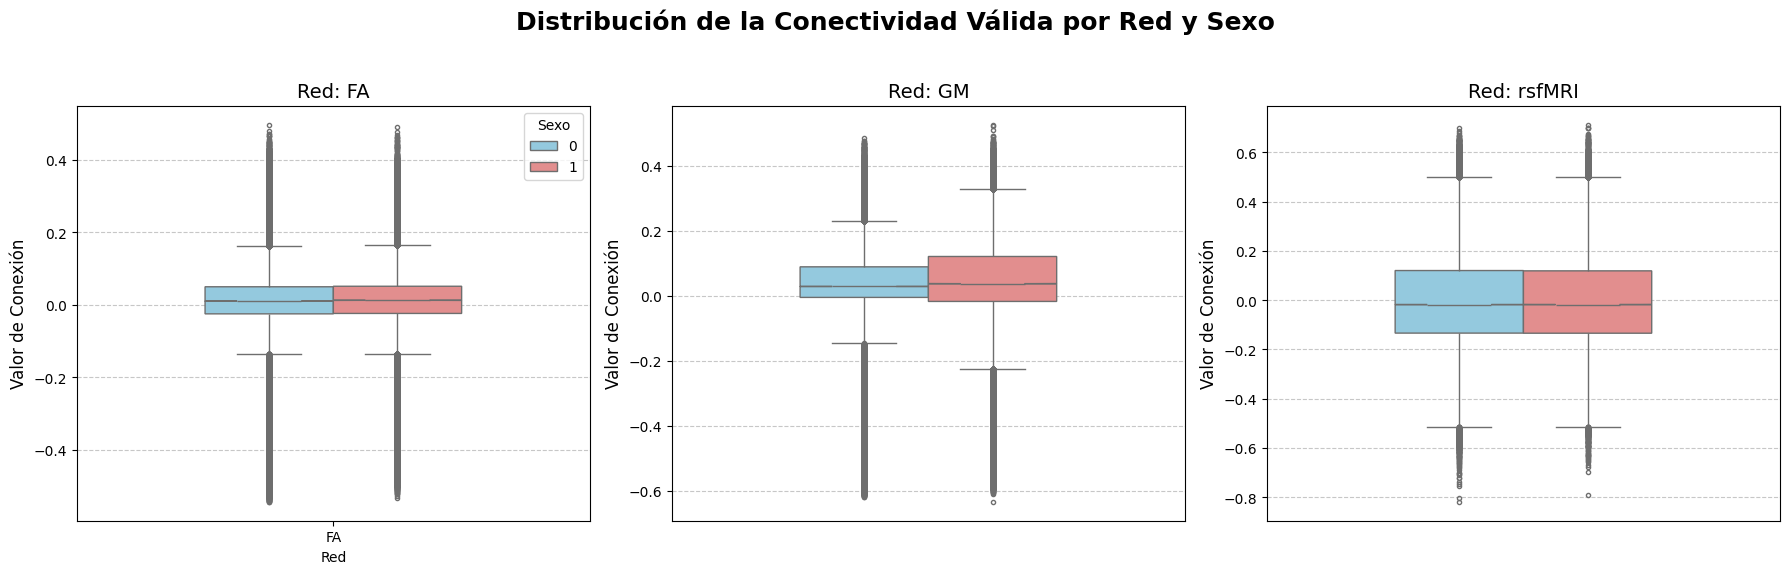

In [ ]:
# Llamar a la función modificada
generar_boxplots_separados_por_red_y_sexo(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    sexes
)

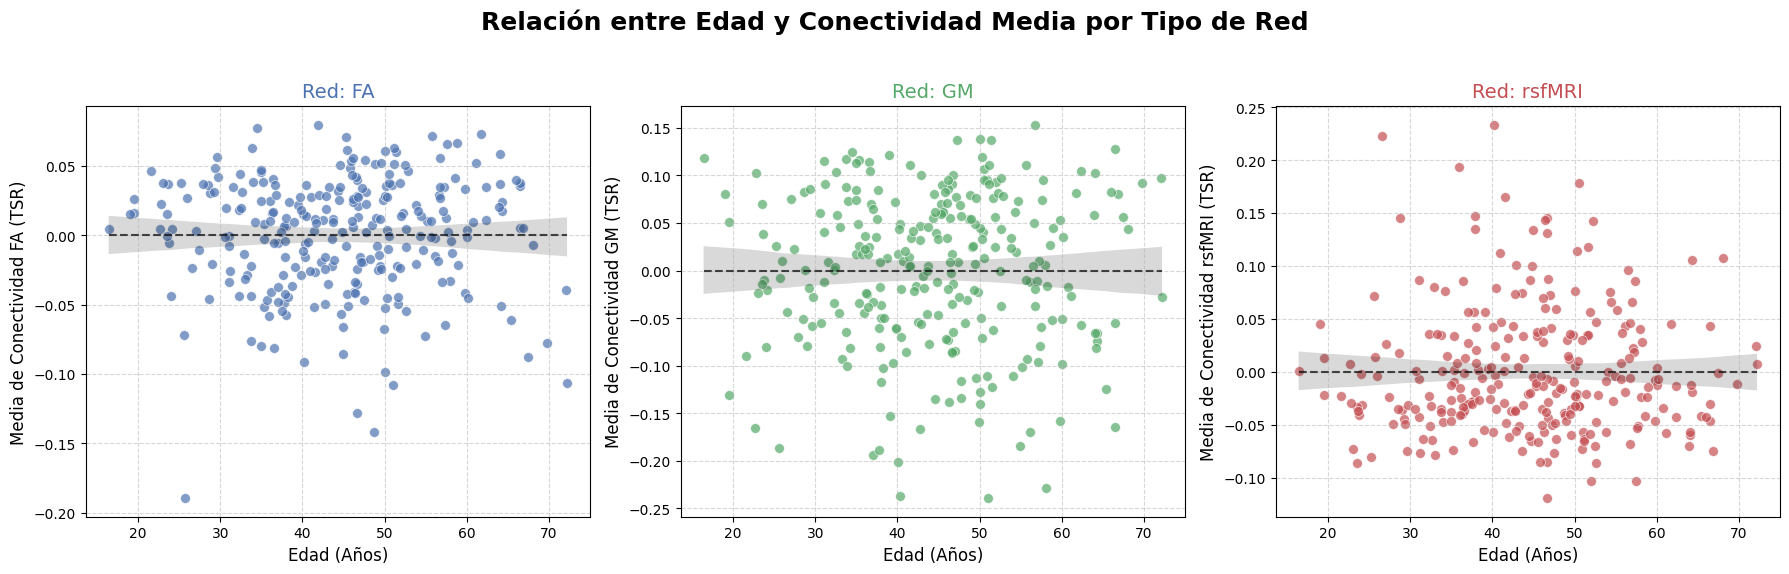

In [ ]:
generar_dispersion_por_red_y_edad(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    ages
)

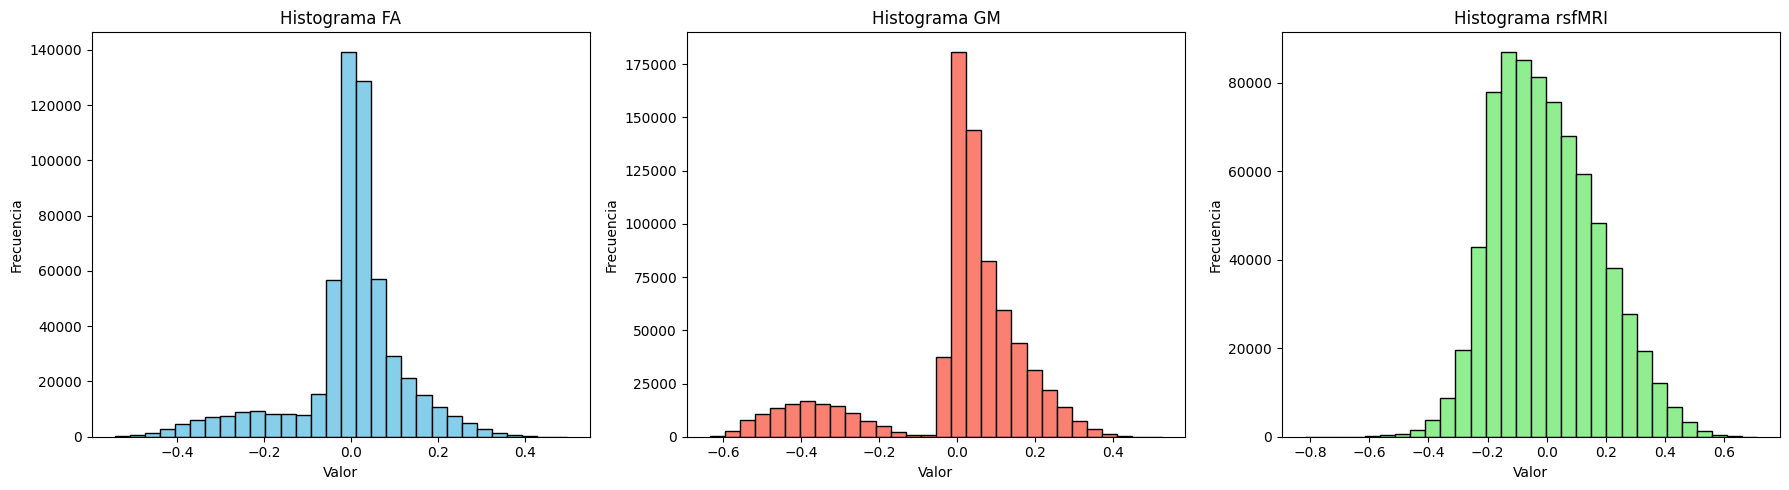

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
def harmonize_tensor_data_nodes(tensor_data, variables):
    """
    Aplica regresión lineal a cada nodo 'i' a través de todos los pacientes 'k'
    para quitar el efecto de las covariables, y devuelve el tensor corregido (residuos).

    Args:
        tensor_data (np.ndarray): Tensor de métricas por nodo (R, N_pacientes).
                                  R=Nodos, N=Pacientes.
        variables (pd.DataFrame): DataFrame con las variables clínicas (predictoras).

    Returns:
        np.ndarray: Tensor (R, N) corregido por el efecto de las variables (residuos de regresión).
    """
    R, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # Inicializar el tensor corregido con ceros
    corrected_tensor = np.zeros_like(tensor_data)

    # Las covariables son las mismas para la corrección de cada nodo
    X = variables.values

    model = LinearRegression()

    # Iterar sobre cada nodo 'i' (filas del tensor)
    for i in range(R):
        # 1. Extraer los datos del nodo 'i' a través de todos los pacientes 'k'
        # y es el vector [N_pacientes] para el nodo 'i'
        y = tensor_data[i, :]

        # 2. Aplicar regresión lineal y calcular residuos
        # La forma de y debe ser (N_pacientes,) y X debe ser (N_pacientes, N_variables)
        model.fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred

        # 3. Almacenar los residuos en la fila 'i' del tensor corregido
        corrected_tensor[i, :] = residuals

    return corrected_tensor

In [ ]:
def generar_boxplots_separados_por_red_y_sexo(
    nodos_volumetricos_tensor: np.ndarray,
    nodos_FA_tensor: np.ndarray,
    nodos_MD_tensor: np.ndarray,
    sex_pacientes: List[str]
):
    """
    Genera boxplots separados (con escala Y propia) para cada modalidad de imagen,
    mostrando la distribución de los valores (Volumen, FA, MD) por sexo.

    ASUME que los tensores de entrada ya están filtrados y tienen la forma
    (n_nodos, n_pacientes) o (n_conexiones_validas, n_pacientes).

    Parámetros:
    - nodos_volumetricos_tensor (np.ndarray): Matriz de valores de Volumen (n_nodos, n_pacientes).
    - nodos_FA_tensor (np.ndarray): Matriz de valores de FA (n_nodos, n_pacientes).
    - nodos_MD_tensor (np.ndarray): Matriz de valores de MD (n_nodos, n_pacientes).
    - sex_pacientes (List[str]): Lista de etiquetas de sexo para cada paciente.
    """

    # --- Mapeo de Nombres de Variables a Títulos de Gráfico ---
    # Asignamos los tensores de entrada a variables internas para usar en la función auxiliar,
    # y definimos el mapeo de nombres para los títulos de los gráficos.

    tensores = {
        'Volumen': nodos_volumetricos_tensor,
        'FA': nodos_FA_tensor,
        'MD': nodos_MD_tensor
    }

    n_pacientes = len(sex_pacientes)

    # --- Función Auxiliar para Crear el DataFrame ---

    def crear_df_red(valores_filtrados: np.ndarray, nombre_red: str, sex_pacientes: List[str]) -> pd.DataFrame:
        # El número de nodos/conexiones válidas es la primera dimensión (eje 0)
        n_elementos_validos = valores_filtrados.shape[0]

        # Transponer para apilar por paciente y luego aplanar:
        # [p1_v1, p1_v2, ..., p1_vN, p2_v1, ...]
        valores_aplanados = valores_filtrados.T.flatten()

        # Crear la lista de sexos repetida por el número de elementos válidos por paciente
        labels_sexo = []
        for i in range(n_pacientes):
            labels_sexo.extend([sex_pacientes[i]] * n_elementos_validos)

        df = pd.DataFrame({
            'Valor': valores_aplanados,
            'Modalidad': nombre_red, # Cambiado de 'Red' a 'Modalidad' para claridad
            'Sexo': labels_sexo
        })
        return df

    # --- Preparar los DataFrames individuales para cada modalidad ---

    dataframes_modalidad: Dict[str, pd.DataFrame] = {}
    for nombre, tensor in tensores.items():
        dataframes_modalidad[nombre] = crear_df_red(tensor, nombre, sex_pacientes)

    # 3. Generar los boxplots en subplots separados (1 fila, 3 columnas)
    modalidades = list(tensores.keys()) # ['Volumen', 'FA', 'MD']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=False)

    fig.suptitle('Distribución de Valores (Volumen, FA, MD) por Modalidad y Sexo', fontsize=18, fontweight='bold')

    for i, modalidad in enumerate(modalidades):
        df_actual = dataframes_modalidad[modalidad]
        ax = axes[i]

        # Generar el boxplot
        sns.boxplot(
            x='Modalidad',
            y='Valor',
            hue='Sexo',
            data=df_actual,
            ax=ax,
            palette=['skyblue', 'lightcoral'],
            fliersize=3,
            notch=True,
            width=0.5
        )

        # Ajustes estéticos por subplot
        ax.set_title(f'Modalidad: {modalidad}', fontsize=14)
        ax.set_ylabel('Valor', fontsize=12) # Se deja genérico 'Valor'
        ax.tick_params(axis='x', labelrotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Ocultar la leyenda y la etiqueta X si no es el primer gráfico
        if i > 0:
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.set_xticks([])
        else:
            # Solo el primer gráfico tiene la leyenda completa
            ax.legend(title='Sexo', loc='upper right')
            ax.set_xticks([0])
            ax.set_xticklabels([modalidad])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

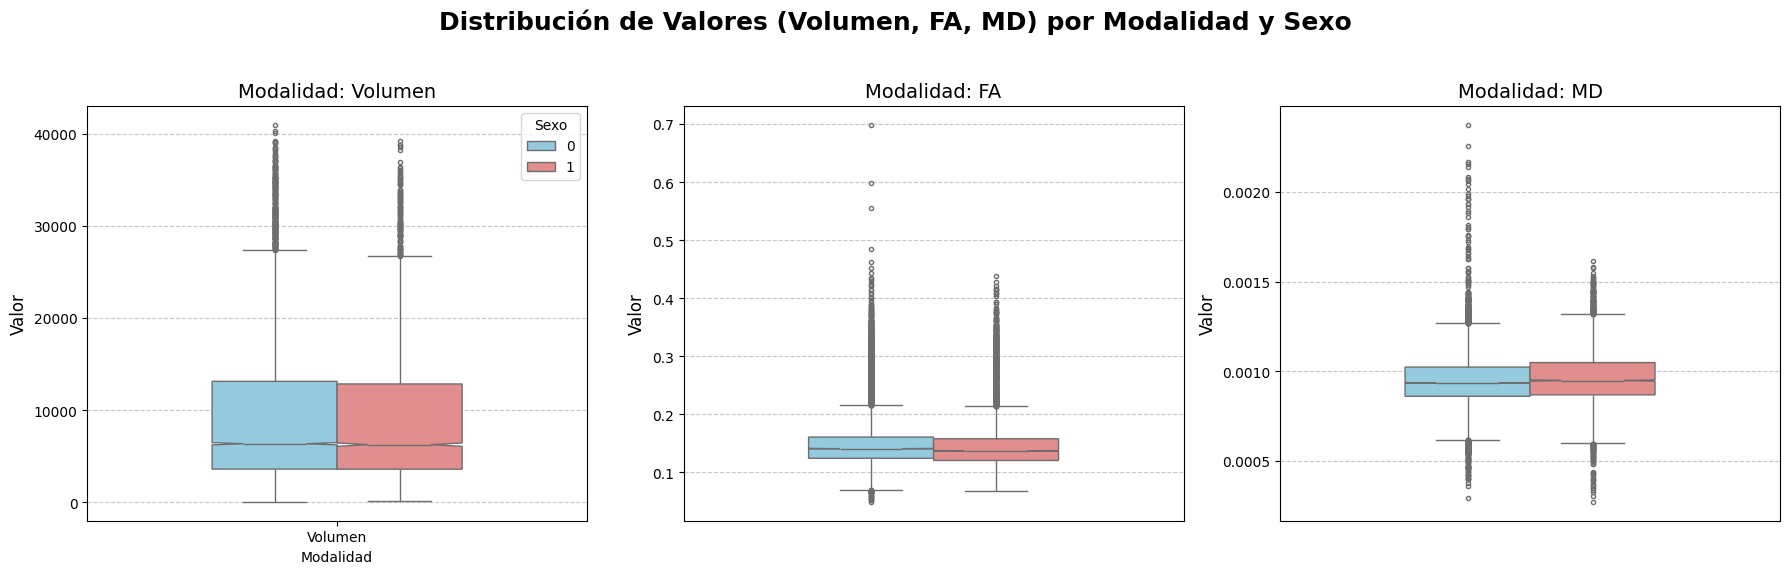

In [ ]:
generar_boxplots_separados_por_red_y_sexo(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    sexes
)

In [ ]:
def generar_dispersion_por_modalidad_y_variable_numerica(
    nodos_volumetricos_tensor: np.ndarray,
    nodos_FA_tensor: np.ndarray,
    nodos_MD_tensor: np.ndarray,
    variable_numerica: List[float], # Variable numérica continua (e.g., Edad, Puntuación Clínica)
    nombre_variable_numerica: str = 'Variable Numérica' # Nombre para la etiqueta del eje X
):
    """
    Genera gráficos de dispersión separados para cada modalidad (Volumen, FA, MD),
    mostrando la media de los nodos/conexiones versus una variable numérica continua
    de los pacientes.

    ASUME que los tensores de entrada ya están filtrados y tienen la forma
    (n_elementos_validos, n_pacientes).

    Parámetros:
    - nodos_volumetricos_tensor (np.ndarray): Matriz de valores de Volumen (M x P).
    - nodos_FA_tensor (np.ndarray): Matriz de valores de FA (M x P).
    - nodos_MD_tensor (np.ndarray): Matriz de valores de MD (M x P).
    - variable_numerica (List[float]): Lista de valores continuos de la variable de interés.
    - nombre_variable_numerica (str): Etiqueta para el eje X.
    """

    # 1. Mapeo de tensores a nombres de modalidades
    tensores = {
        'Volumen': nodos_volumetricos_tensor,
        'FA': nodos_FA_tensor,
        'MD': nodos_MD_tensor
    }

    # Lista de nombres de las modalidades para el DataFrame
    modalidades = list(tensores.keys())

    # 2. Calcular la MEDIA de los elementos válidos (nodos/conexiones) para CADA paciente
    # El eje a promediar es el 0 (n_elementos_validos), dejando un array de forma (n_pacientes,)
    medias: Dict[str, np.ndarray] = {}
    for nombre, tensor in tensores.items():
        # Calcular la media a lo largo de la primera dimensión (eje 0)
        medias[f'{nombre}'] = np.mean(tensor, axis=0)

    # 3. Preparar el DataFrame
    df_data = pd.DataFrame({
        nombre_variable_numerica: variable_numerica
    })

    # Agregar las medias de las modalidades al DataFrame
    for nombre, media in medias.items():
        df_data[nombre] = media

    # 4. Generar los gráficos de dispersión en subplots separados
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=False)

    columnas_media = modalidades
    colores = ['#4C72B0', '#55A868', '#C44E52'] # Azul, Verde, Rojo

    titulo_supt = f'Relación entre {nombre_variable_numerica} y la Media de la Modalidad'
    fig.suptitle(titulo_supt, fontsize=18, fontweight='bold')

    for i, modalidad in enumerate(modalidades):
        col_y = columnas_media[i]
        color = colores[i]
        ax = axes[i]

        # Generar el gráfico de dispersión (Scatter Plot)
        sns.scatterplot(
            x=nombre_variable_numerica,
            y=col_y,
            data=df_data,
            ax=ax,
            color=color,
            s=50, # Tamaño de los puntos
            alpha=0.7 # Transparencia
        )

        # Opcional: Añadir línea de regresión para visualizar la tendencia
        sns.regplot(
            x=nombre_variable_numerica,
            y=col_y,
            data=df_data,
            ax=ax,
            scatter=False, # Solo dibuja la línea de tendencia
            color='black',
            line_kws={'linestyle': '--', 'linewidth': 1.5, 'alpha': 0.7}
        )

        # Ajustes estéticos por subplot
        ax.set_title(f'Modalidad: {modalidad}', fontsize=14, color=color)
        ax.set_xlabel(nombre_variable_numerica, fontsize=12)
        ax.set_ylabel(f'Media de Valores {modalidad}', fontsize=12)
        ax.grid(axis='both', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

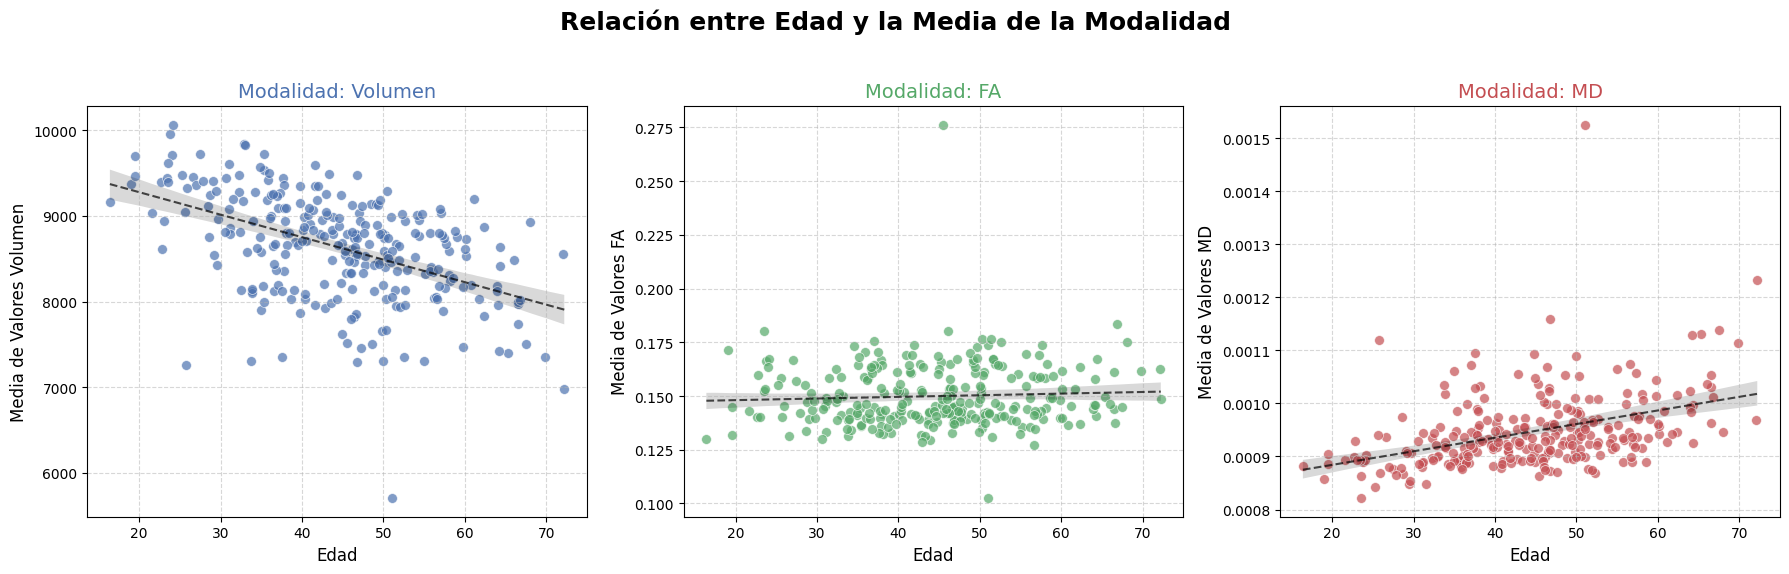

In [ ]:
generar_dispersion_por_modalidad_y_variable_numerica(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    ages,
    "Edad"
)

In [ ]:
nodos_volumetricos_tensor = harmonize_tensor_data_nodes(nodos_volumetricos_tensor, variables)
nodos_FA_tensor = harmonize_tensor_data_nodes(nodos_FA_tensor, variables)
nodos_MD_tensor = harmonize_tensor_data_nodes(nodos_MD_tensor, variables)

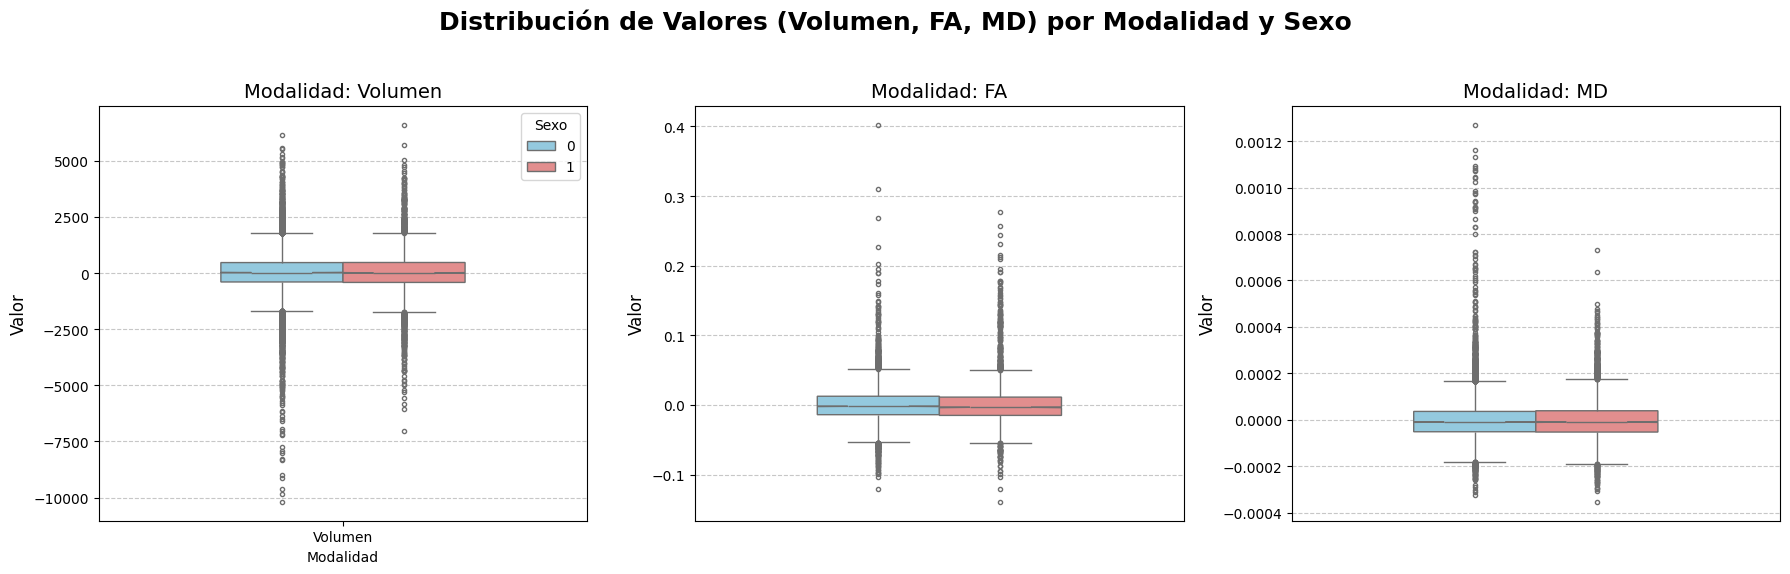

In [ ]:
generar_boxplots_separados_por_red_y_sexo(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    sexes
)

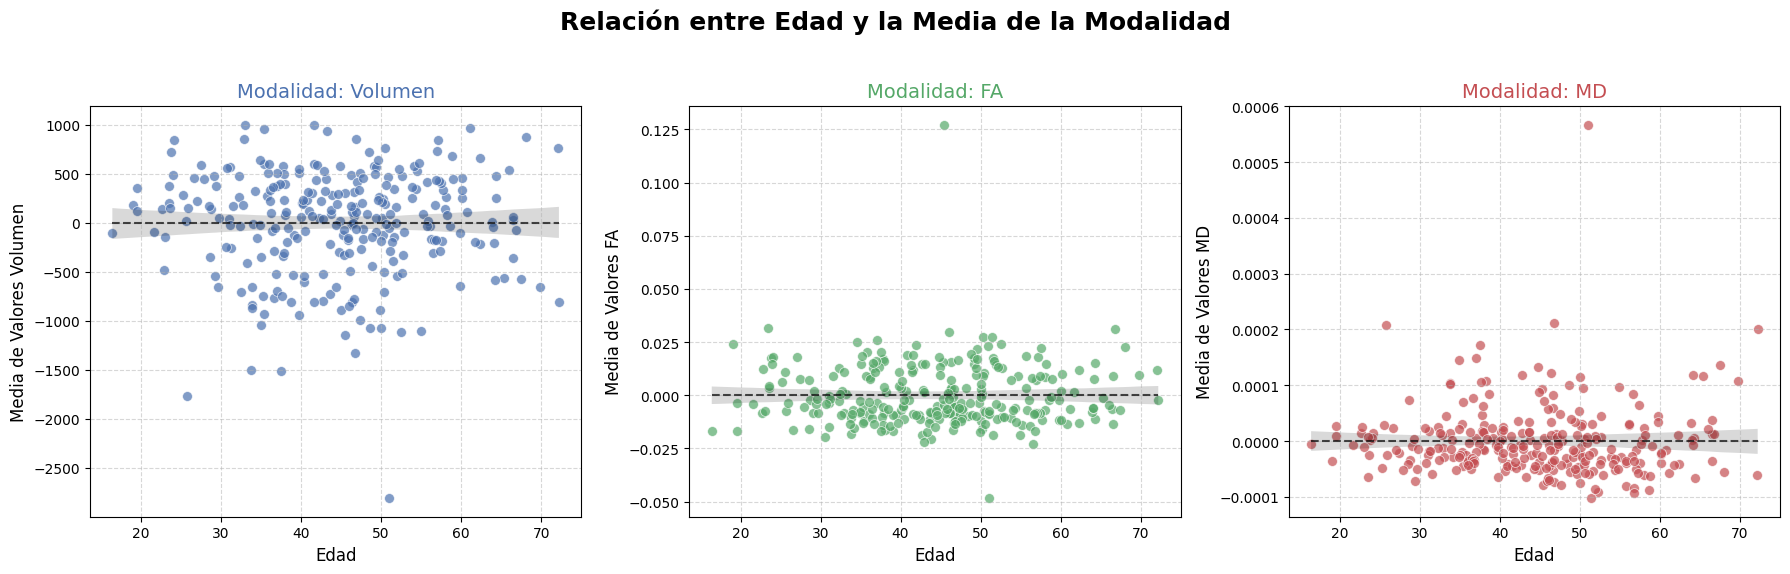

In [ ]:
generar_dispersion_por_modalidad_y_variable_numerica(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    ages,
    "Edad"
)

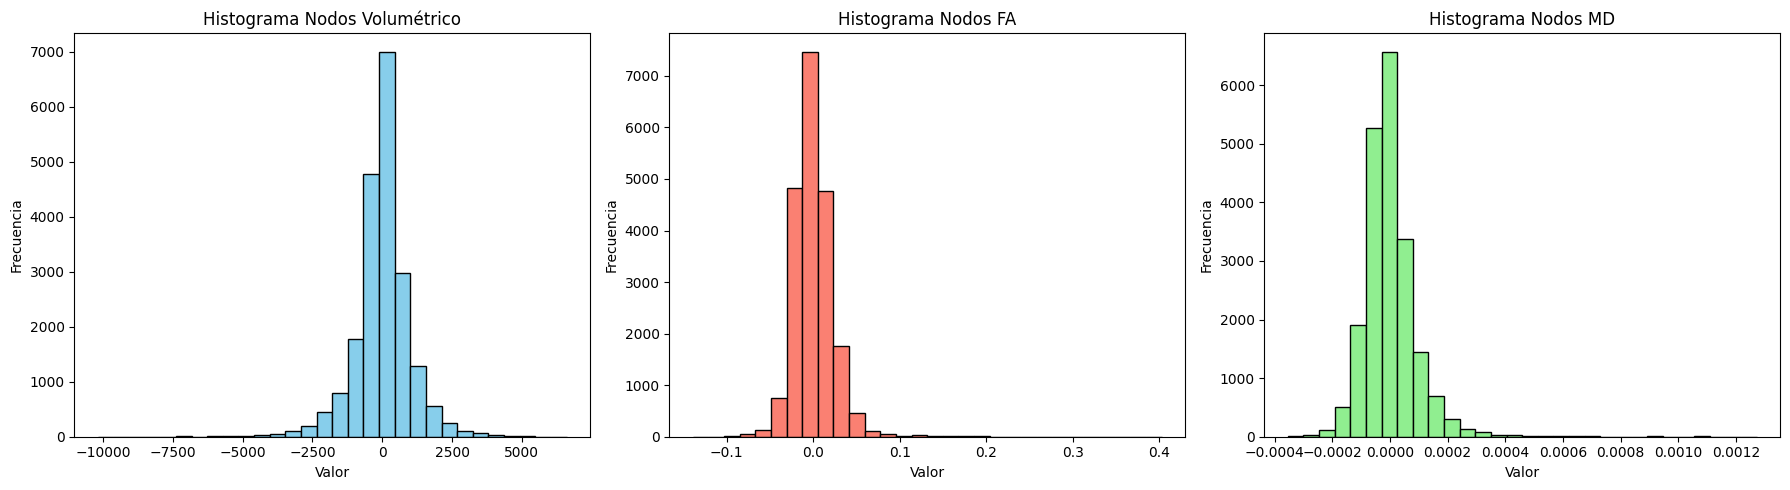

In [ ]:
# Aplanar todos los valores de nodos_volumetricos
valores_nodos_volumetricos = [valor for nodo in nodos_volumetricos_tensor for valor in nodo]
valores_nodos_volumetricos = np.array(valores_nodos_volumetricos)

# Aplanar todos los valores de nodos_FA
valores_nodos_FA = [valor for nodo in nodos_FA_tensor for valor in nodo]
valores_nodos_FA = np.array(valores_nodos_FA)

# Aplanar todos los valores de nodos_MD
valores_nodos_MD = [valor for nodo in nodos_MD_tensor for valor in nodo]
valores_nodos_MD = np.array(valores_nodos_MD)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_nodos_volumetricos, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma Nodos Volumétrico')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_nodos_FA, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma Nodos FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_nodos_MD, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma Nodos MD')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Imputación (MICE)


In [ ]:
# Función para aplicar la máscara y poner 0 donde sea True
def aplicar_mascara_nan(tensor, nan_mask):
    tensor_modificado = tensor.copy()
    tensor_modificado[nan_mask] = np.nan
    return tensor_modificado

FA_matrices_tensor = aplicar_mascara_nan(FA_matrices_tensor, FA_nan_mask)
GM_matrices_tensor = aplicar_mascara_nan(GM_matrices_tensor, GM_nan_mask)
rsfMRI_matrices_tensor = aplicar_mascara_nan(rsfMRI_matrices_tensor, rsfMRI_nan_mask)

In [ ]:
def imputar_tensor(tensor):
    """
    Imputa valores NaN en un tensor (n_i, n_j, n_k) de conectividad.

    Transforma el problema 3D en una matriz 2D (Sujetos x Conexiones),
    aplica MICE (Regresión Iterativa) y reconstruye el tensor respetando
    la simetría.

    Parámetros:
    -----------
    tensor : np.ndarray
        Tensor de forma (n_nodes, n_nodes, n_subjects).
        Se asume que las matrices de conectividad son simétricas.

    Retorna:
    --------
    np.ndarray
        Tensor con los valores imputados y simetría garantizada.
    """
    n_i, n_j, n_k = tensor.shape

    if n_i != n_j:
        raise ValueError("Las matrices de conectividad deben ser cuadradas (n_i == n_j).")

    # 1. Reordenar ejes: Scikit-learn espera (muestras, características)
    # Transformamos (N, N, K) -> (K, N, N)
    datos_sujetos = np.moveaxis(tensor, -1, 0)

    # 2. Aplanar y extraer solo el triángulo superior
    # Las matrices de conectividad son simétricas; usar ambos lados duplica el ruido
    # y rompe la regresión. Solo necesitamos los bordes únicos.
    indices_triu = np.triu_indices(n_i, k=1) # k=1 para excluir la diagonal si es irrelevante (usualmente 0 o 1)

    # Extraemos los valores: Forma resultante (n_subjects, n_edges)
    X = datos_sujetos[:, indices_triu[0], indices_triu[1]]

    # 3. Configurar el Imputador (MICE)
    # Usamos BayesianRidge porque maneja bien problemas donde n_features > n_samples
    imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=42,
        initial_strategy='mean',
        skip_complete=True,
        n_nearest_features=50,
        verbose=1
    )

    print(f"Iniciando imputación sobre {X.shape[1]} conexiones para {n_k} sujetos...")

    # 4. Ajustar y Transformar
    X_imputed = imputer.fit_transform(X)

    # 5. Reconstruir el Tensor 3D
    tensor_imputado = np.zeros_like(datos_sujetos)

    # Llenamos cada sujeto
    for k in range(n_k):
        matriz = np.zeros((n_i, n_j))
        # Rellenar triángulo superior
        matriz[indices_triu] = X_imputed[k]
        # Reflejar al triángulo inferior (Simetría)
        matriz = matriz + matriz.T
        # Opcional: Rellenar diagonal (si era 1 o 0 originalmente, ajustar aquí)
        np.fill_diagonal(matriz, 0)

        tensor_imputado[k] = matriz

    # Devolver a la forma original (N, N, K)
    return np.moveaxis(tensor_imputado, 0, -1)

In [ ]:
FA_matrices_tensor = imputar_tensor(FA_matrices_tensor)
GM_matrices_tensor = imputar_tensor(GM_matrices_tensor)
rsfMRI_matrices_tensor = imputar_tensor(rsfMRI_matrices_tensor)

Iniciando imputación sobre 2850 conexiones para 270 sujetos...
[IterativeImputer] Completing matrix with shape (270, 2850)
[IterativeImputer] Change: 59.438415524553456, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 19.184320900174846, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 14.963783310237034, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 12.814421227410811, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 12.489849909697519, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 12.095949373288619, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 11.839014431077105, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 11.679278448603146, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 11.981337528716907, scaled tolerance: 0.0004973214659798774 
[IterativeImputer] Change: 11.80370977127381, scaled tolerance: 0.0004973214659798774

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Completing matrix with shape (270, 2850)
[IterativeImputer] Change: 81.61584003889462, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 18.67904252786903, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 15.444699676340393, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 13.421707734266562, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 12.49925983348965, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 12.4274944188219, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 12.49031186505427, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 12.34486137102892, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 12.010988118341814, scaled tolerance: 0.000526470203647434 
[IterativeImputer] Change: 11.970080763854515, scaled tolerance: 0.000526470203647434 
Iniciando imputación sobre 2850 conexiones para 270 sujetos...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Completing matrix with shape (270, 2850)
[IterativeImputer] Change: 104.26802116592074, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 43.57131673157036, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 42.019639667749416, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 43.047631016025704, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 42.77780592957368, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 43.139649327166474, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 41.623070446525006, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 41.222846152512076, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 42.31023674779758, scaled tolerance: 0.0007119241891681598 
[IterativeImputer] Change: 40.221492564725146, scaled tolerance: 0.0007119241891681598 


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


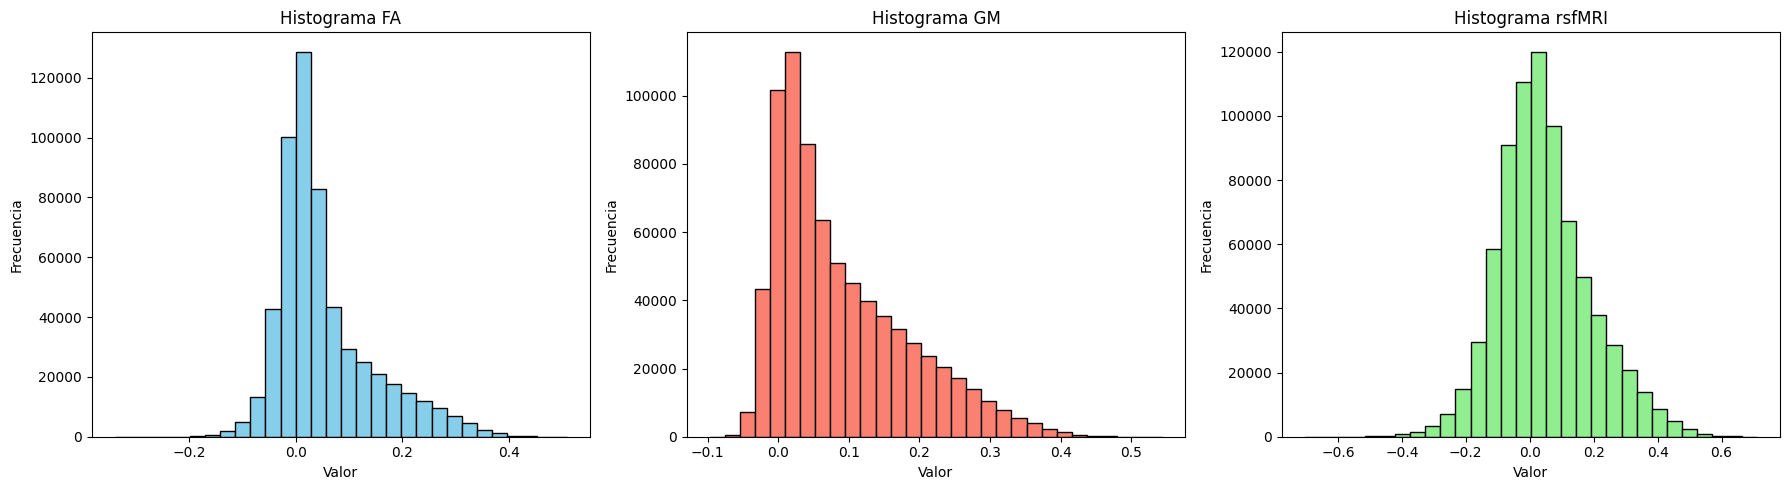

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# ComBat para corrección de origen

In [ ]:
copia_FA_matrices = FA_matrices_tensor
copia_GM_matrices = GM_matrices_tensor
copia_rsfMRI_matrices = rsfMRI_matrices_tensor

In [ ]:
FA_matrices_tensor = copia_FA_matrices
GM_matrices_tensor = copia_GM_matrices
rsfMRI_matrices_tensor = copia_rsfMRI_matrices

In [ ]:
def generar_scatter_pca_por_red_y_origen(
    tensor_FA: np.ndarray,
    tensor_GM: np.ndarray,
    tensor_rsfMRI: np.ndarray,
    mascara_anulada_FA: np.ndarray,
    mascara_anulada_GM: np.ndarray,
    mascara_anulada_rsfMRI: np.ndarray,
    origen_pacientes: List[str]
):
    """
    Realiza PCA sobre las matrices de conectividad de cada red y genera
    un diagrama de dispersión de PC1 vs PC2 en subplots, coloreado por el lugar de origen.
    """

    # 1. Extraer y filtrar los valores (Sujetos x Conexiones Válidas)

    # Nota: Asumo que 'obtener_triangulo_superior_derecho_filtrado' devuelve
    # un array de (N_Sujetos, N_Conexiones_Validas)
    valores_filtrados_FA = obtener_triangulo_superior_derecho_filtrado(tensor_FA, mascara_anulada_FA)
    print(valores_filtrados_FA.shape)
    valores_filtrados_GM = obtener_triangulo_superior_derecho_filtrado(tensor_GM, mascara_anulada_GM)
    valores_filtrados_rsfMRI = obtener_triangulo_superior_derecho_filtrado(tensor_rsfMRI, mascara_anulada_rsfMRI)

    # Diccionario para iterar fácilmente
    datos_redes = {
        'FA': valores_filtrados_FA,
        'GM': valores_filtrados_GM,
        'rsfMRI': valores_filtrados_rsfMRI
    }
    redes = ['FA', 'GM', 'rsfMRI']

    # Paleta de colores para el origen/site
    palette_origen = ['skyblue', 'lightcoral', 'lightgreen']

    # 2. Configurar los subplots (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    fig.suptitle('Análisis de Componentes Principales (PCA) - Efecto de Sitio por Red',
                 fontsize=18, fontweight='bold')

    # 3. Iterar sobre cada red, aplicar PCA y generar el Scatter Plot
    for i, red in enumerate(redes):

        valores_filtrados = datos_redes[red]
        ax = axes[i]

        # A. Aplicar PCA (2 componentes)
        pca = PCA(n_components=2)
        componentes_principales = pca.fit_transform(valores_filtrados)

        # B. Crear DataFrame de PCA
        df_pca = pd.DataFrame(data = componentes_principales,
                              columns = ['PC1', 'PC2'])
        df_pca['Origen'] = origen_pacientes

        # Varianza Explicada
        varianza_explicada = pca.explained_variance_ratio_ * 100

        # C. Generar el Scatter Plot
        sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='Origen',
            data=df_pca,
            ax=ax,
            palette=palette_origen,
            s=80,
            style='Origen',
            edgecolor='w', # Borde blanco para mejor distinción
            legend=(i == 0) # Mostrar leyenda solo en el primer gráfico
        )

        # D. Ajustes estéticos
        ax.set_title(f'Red: {red}', fontsize=14)
        ax.set_xlabel(f'PC 1 ({varianza_explicada[0]:.2f}% Varianza)', fontsize=12)
        ax.set_ylabel(f'PC 2 ({varianza_explicada[1]:.2f}% Varianza)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

        if i == 0:
             # Ajustar la leyenda en el primer subplot
            ax.legend(title='Origen', loc='upper right', frameon=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el suptitle
    plt.show()

(270, 2088)


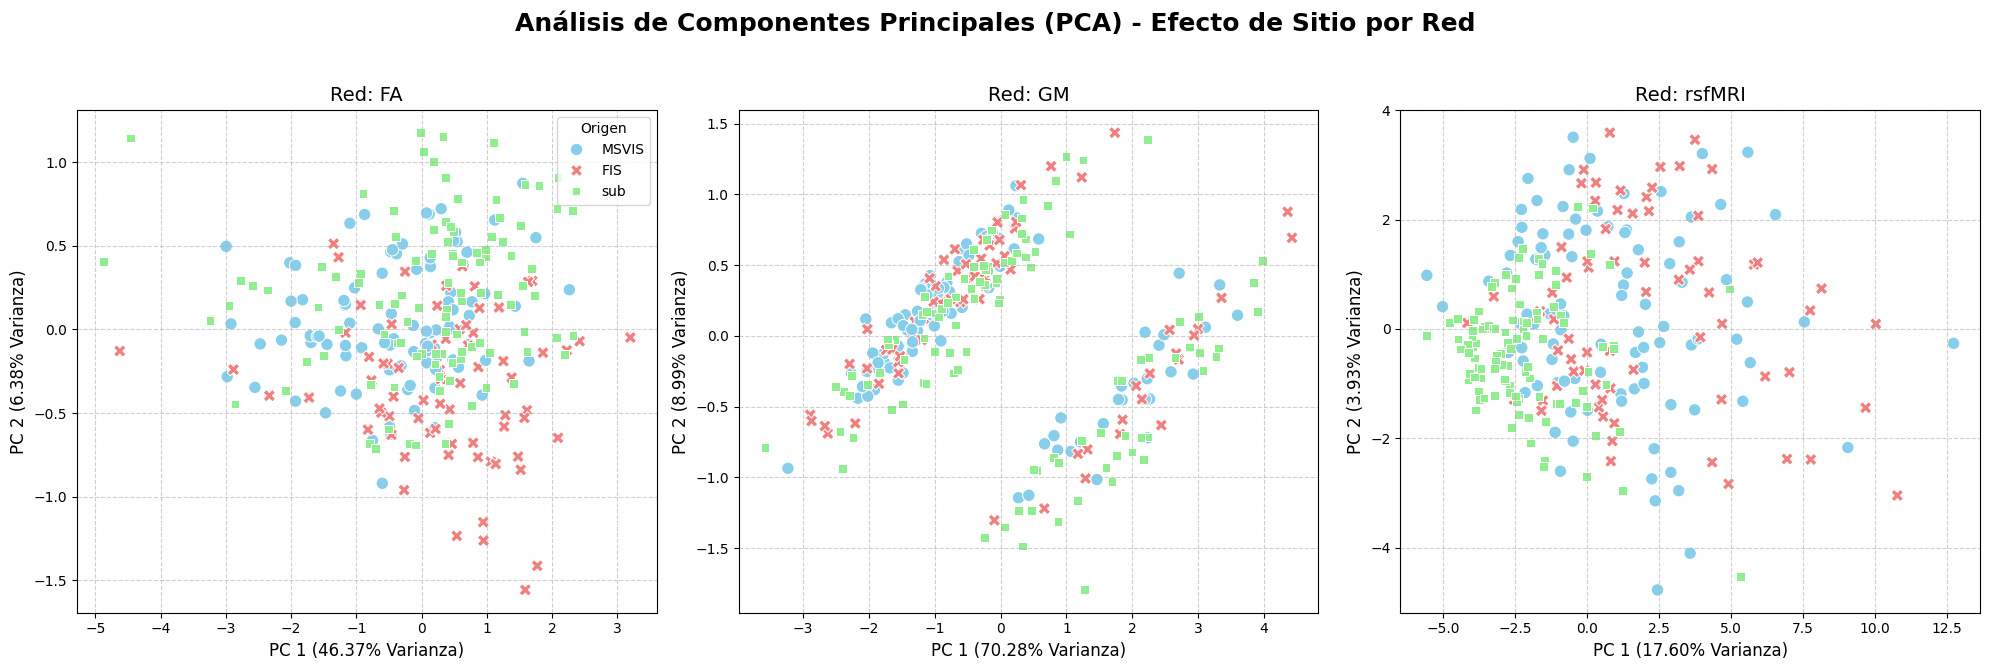

In [ ]:
generar_scatter_pca_por_red_y_origen(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    sites
)

In [ ]:
def harmonize_tensor_data(tensor_data, variables, name_batch, names_cat, null_conections):
    """
    Vectoriza las conexiones (triángulo superior) de un tensor 3D,
    aplica ComBat, y reconstruye el tensor corregido sin usar squareform.

    Args:
        tensor_data (np.ndarray): Tensor de conectividad (R, R, N_pacientes).
        variables (pd.DataFrame): DataFrame con las variables clínicas.
        name_batch (str): Nombre de la columna de batch en variables.
        names_cat (list): Nombres de las columnas categóricas en variables.
        null_conections (np.ndarray): Matriz booleana (R, R) con True donde la conexión fue completamente anulada

    Returns:
        np.ndarray: Tensor 3D corregido por el efecto de sitio.
    """
    R, _, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # 1. Vectorización: Crear la matriz de Features x Pacientes
    features_list = []

    for i in range(R):
        for j in range(i+1, R):
            if not null_conections[i, j]:
                features_list.append(tensor_data[i, j, :])

    # Matriz de entrada para ComBat: [N_conexiones x N_pacientes]
    dat_combat = np.vstack(features_list)

    print(f"  > Datos de entrada ComBat: {dat_combat.shape} (Features x Pacientes)")

    # 2. Armonización ComBat
    harmonized_data = neuroCombat(
        dat=dat_combat,
        covars=variables,
        batch_col=name_batch,
        categorical_cols = names_cat
    )['data']

    # 3. De-vectorización: Reconstruir el Tensor Corregido
    corrected_tensor = np.zeros_like(tensor_data)  # inicializamos todo en cero para garantizar diagonal nula

    k = 0

    for i in range(R):
        for j in range(i+1, R):
            if not null_conections[i, j]:
                value = harmonized_data[k, :]
                corrected_tensor[i, j, :] = value
                corrected_tensor[j, i, :] = value
                k += 1
            else:
                corrected_tensor[i, j, :] = tensor_data[i, j, :]
                corrected_tensor[j, i, :] = tensor_data[j, i, :]

    # diagonal ya está en cero por la inicialización con np.zeros_like

    print(f"  > Tensor corregido final: {corrected_tensor.shape}")
    return corrected_tensor

In [ ]:
# 1. Creamos un DataFrame temporal con TODO junto
# Esto asegura que las filas estén alineadas y sea fácil de manipular
vars_to_regression = pd.DataFrame({
    'sites': sites,
    'ages': ages,
    'sexes': sexes,
    'ddes': ddes,
    'edsses': edsses,
    'mstypes': mstypes,
    'controls_mses': controls_mses
})

# 2. Aplicamos label encoding
vars_to_regression['sites'] = vars_to_regression['sites'].astype('category').cat.codes

FA_matrices_tensor = harmonize_tensor_data(FA_matrices_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"], FA_null_conections)
GM_matrices_tensor = harmonize_tensor_data(GM_matrices_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"], GM_null_conections)
rsfMRI_matrices_tensor = harmonize_tensor_data(rsfMRI_matrices_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"], rsfMRI_null_conections)

  > Datos de entrada ComBat: (2088, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)
  > Datos de entrada ComBat: (2789, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)
  > Datos de entrada ComBat: (2850, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)


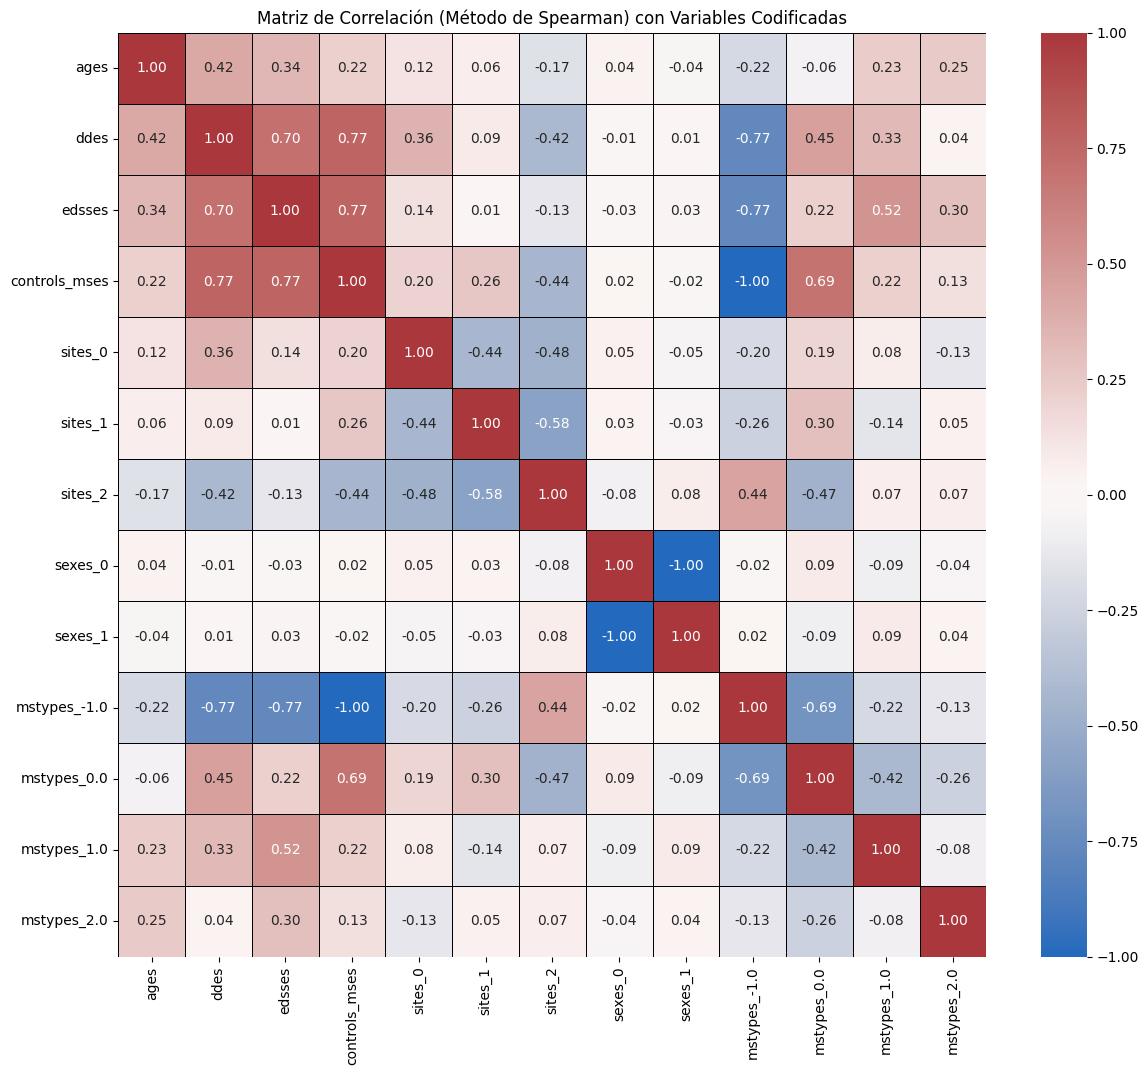

In [ ]:
import pandas as pd

# Suponiendo que 'vars_to_regression' ya está cargado...

# --- PASO 1: One-Hot Encoding para Nominales ---
nominal_vars = ['sites', 'sexes', 'mstypes']
# Las nuevas columnas dummies se añaden, y las originales se eliminan si se usa 'get_dummies'
vars_encoded = pd.get_dummies(vars_to_regression, columns=nominal_vars, drop_first=False)

# --- PASO 2: Cálculo de la Matriz de Correlación ---
# Usamos Spearman, que es más adecuado para variables ordinales como EDSS/DDE
# y es aceptable para continuas y binarias (dummies)
correlation_matrix = vars_encoded.corr(method='spearman')

# --- PASO 3: Visualización ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='vlag', # Un esquema de color divergente es ideal para correlación (+/-)
    linewidths=.5,
    linecolor='black'
)
plt.title('Matriz de Correlación (Método de Spearman) con Variables Codificadas')
plt.show()

(270, 2088)


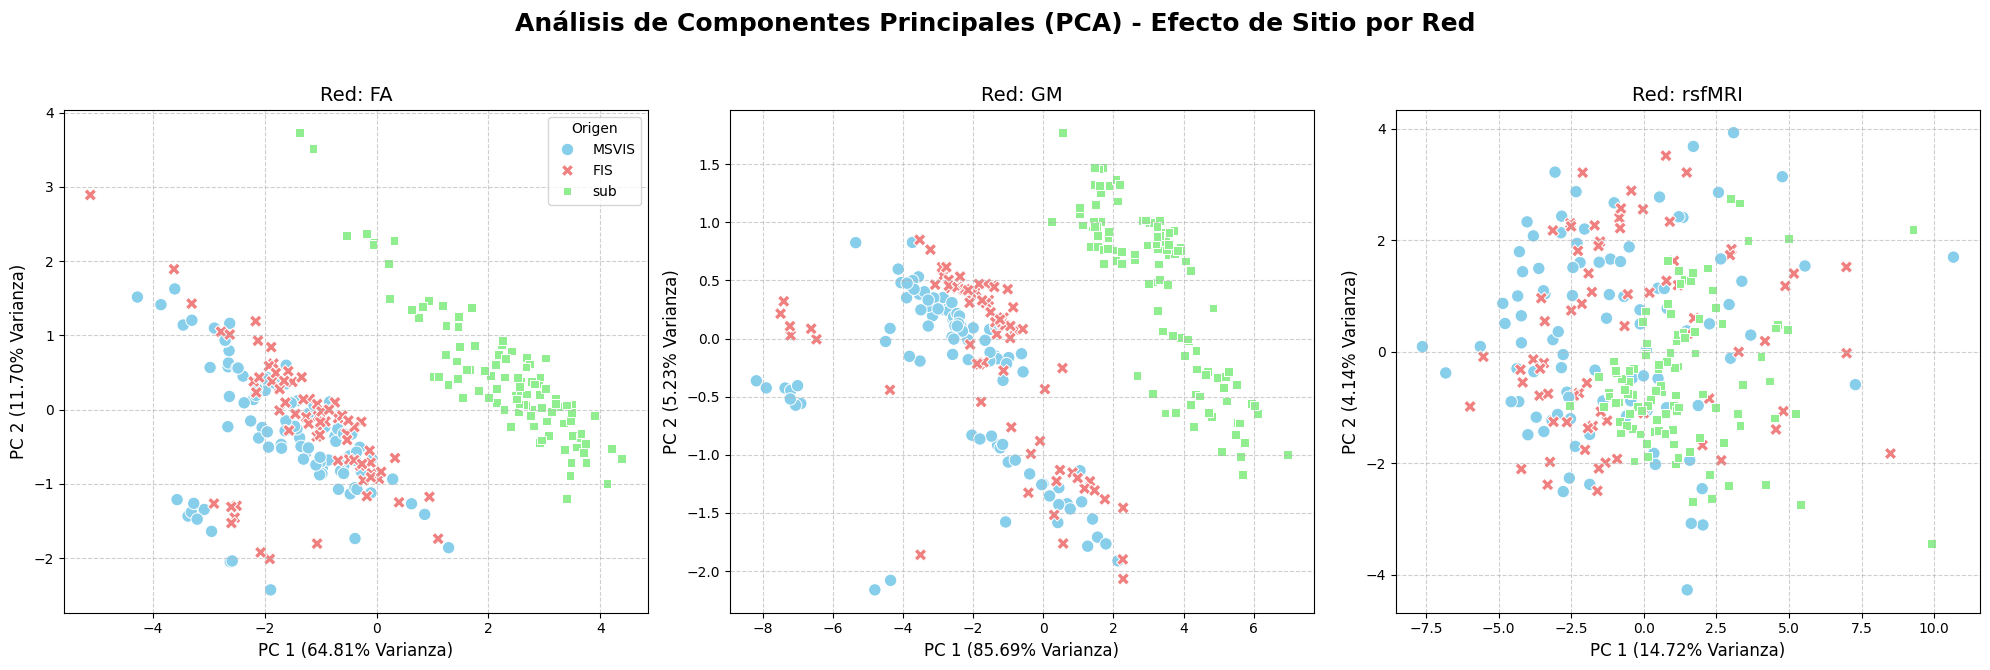

In [ ]:
generar_scatter_pca_por_red_y_origen(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    sites
)

  > Datos de entrada ComBat: (2088, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)
  > Datos de entrada ComBat: (2789, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)
  > Datos de entrada ComBat: (2850, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 76, 270)
(270, 2088)


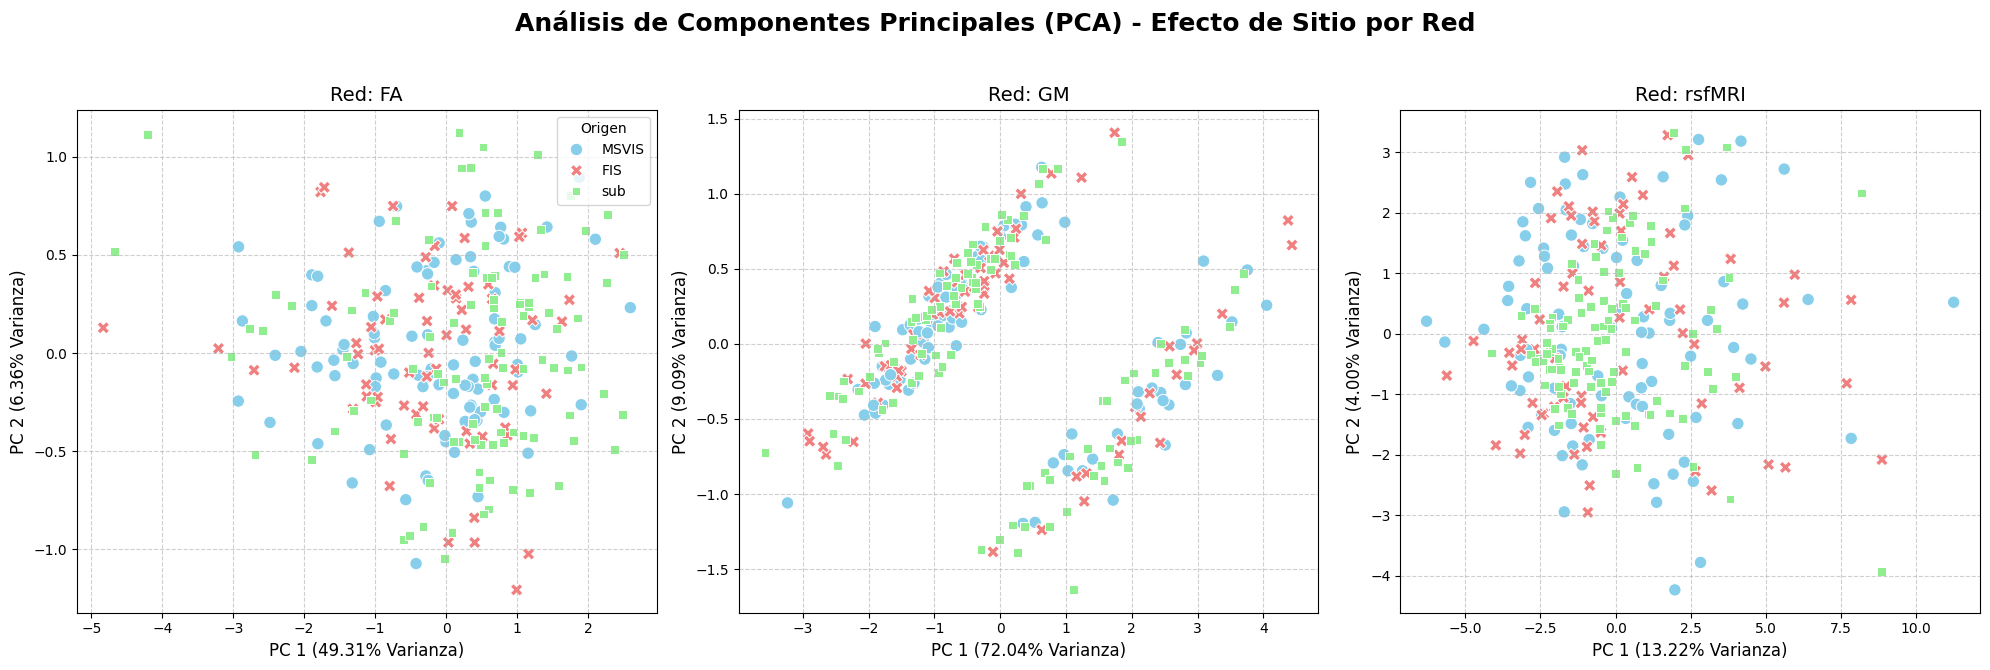

In [ ]:
# 1. Creamos un DataFrame temporal con TODO junto
# Esto asegura que las filas estén alineadas y sea fácil de manipular
vars_to_regression_noclinic = pd.DataFrame({
    'sites': sites,
    'ages': ages,
    'sexes': sexes,
    'mstypes': mstypes
})

# 2. Aplicamos label encoding
vars_to_regression_noclinic['sites'] = vars_to_regression_noclinic['sites'].astype('category').cat.codes

FA_matrices_tensor = harmonize_tensor_data(copia_FA_matrices, vars_to_regression_noclinic, "sites", ["sexes", "mstypes"], FA_null_conections)
GM_matrices_tensor = harmonize_tensor_data(copia_GM_matrices, vars_to_regression_noclinic, "sites", ["sexes", "mstypes"], GM_null_conections)
rsfMRI_matrices_tensor = harmonize_tensor_data(copia_rsfMRI_matrices, vars_to_regression_noclinic, "sites", ["sexes", "mstypes"], rsfMRI_null_conections)

generar_scatter_pca_por_red_y_origen(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    FA_null_conections,
    GM_null_conections,
    rsfMRI_null_conections,
    sites
)

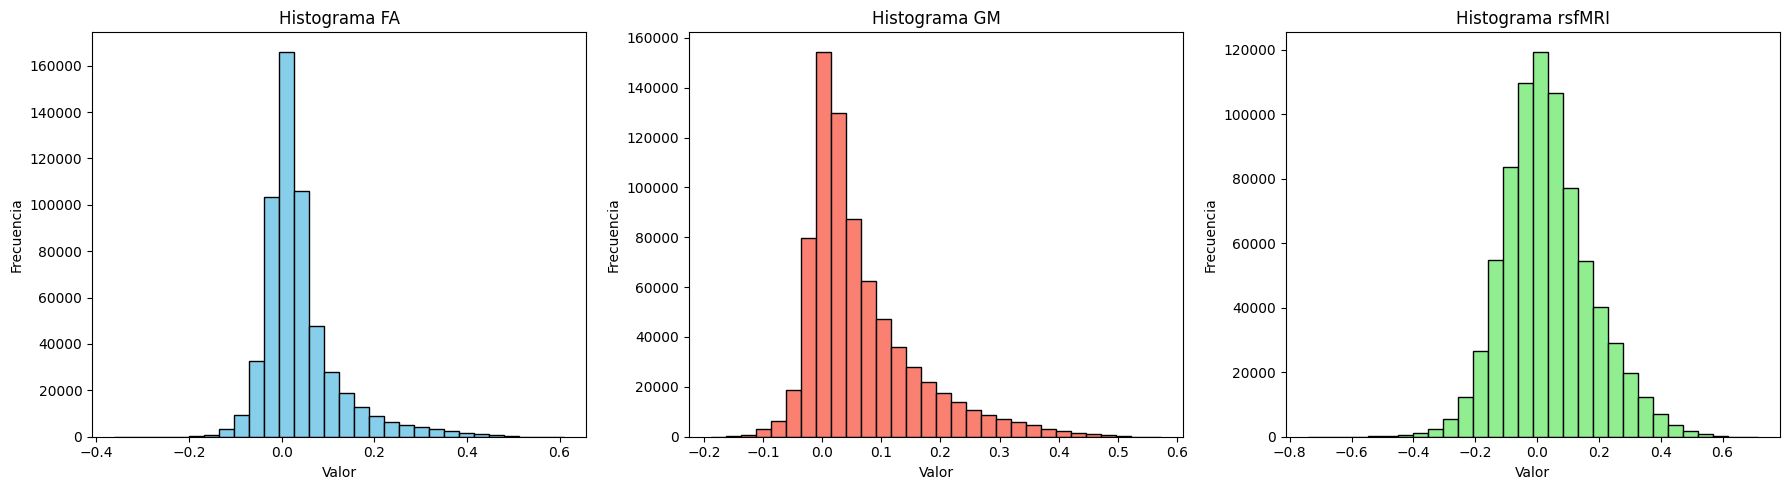

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
def generar_scatter_pca_multiple_metricas(
    tensor_vol: np.ndarray,
    tensor_fa: np.ndarray,
    tensor_md: np.ndarray,
    origen_pacientes: List[str]
):
    """
    Realiza PCA sobre tres tensores de métricas por nodo (Volumétrico, FA, MD)
    y genera un diagrama de dispersión de PC1 vs PC2 en subplots,
    coloreado por el lugar de origen (batch).

    Args:
        tensor_vol (np.ndarray): Tensor de métricas volumétricas (R, N_pacientes).
        tensor_fa (np.ndarray): Tensor de métricas FA (R, N_pacientes).
        tensor_md (np.ndarray): Tensor de métricas MD (R, N_pacientes).
        origen_pacientes (List[str]): Lista o array con el origen/batch de cada paciente.
    """

    # 1. Preparación de los datos y Metadatos

    # Diccionario para iterar fácilmente sobre los tensores
    datos_metricas = {
        'Volumétrico': tensor_vol,
        'FA': tensor_fa,
        'MD': tensor_md
    }
    nombres_metricas = ['Volumétrico', 'FA', 'MD']

    # Verificación de la dimensión de pacientes (N)
    N = tensor_vol.shape[1]
    if len(origen_pacientes) != N:
         raise ValueError(
            f"La longitud de 'origen_pacientes' ({len(origen_pacientes)}) "
            f"no coincide con el número de pacientes ({N})."
        )

    # Paleta de colores para el origen/site
    # Se usa una paleta de Seaborn que se ajusta automáticamente al número de sitios
    num_sitios = len(np.unique(origen_pacientes))
    palette_origen = sns.color_palette("Set1", n_colors=num_sitios)

    # 2. Configurar los subplots (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    fig.suptitle('Análisis de Componentes Principales (PCA) - Efecto de Sitio por Métrica Nodular',
                 fontsize=18, fontweight='bold')

    # 3. Iterar sobre cada métrica, aplicar PCA y generar el Scatter Plot
    for i, metrica in enumerate(nombres_metricas):

        tensor_data = datos_metricas[metrica]
        # R, N_ = tensor_data.shape # R=Nodos, N_=Pacientes
        ax = axes[i]

        # A. Transponer los datos para PCA: (Features x Muestras) -> (Muestras x Features)
        # Es decir: (Nodos, Pacientes) -> (Pacientes, Nodos)
        data_for_pca = tensor_data.T

        # B. Aplicar PCA (2 componentes)
        pca = PCA(n_components=2)
        componentes_principales = pca.fit_transform(data_for_pca)

        # C. Crear DataFrame de PCA para visualización
        df_pca = pd.DataFrame(data = componentes_principales,
                              columns = ['PC1', 'PC2'])
        df_pca['Origen'] = origen_pacientes

        # Varianza Explicada
        varianza_explicada = pca.explained_variance_ratio_ * 100

        # D. Generar el Scatter Plot
        sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='Origen',
            data=df_pca,
            ax=ax,
            palette=palette_origen,
            s=80,
            style='Origen',
            edgecolor='w', # Borde blanco para mejor distinción
            legend=(i == 0) # Mostrar leyenda solo en el primer gráfico (más limpio)
        )

        # E. Ajustes estéticos
        ax.set_title(f'Métrica: {metrica}', fontsize=14)
        ax.set_xlabel(f'PC 1 ({varianza_explicada[0]:.2f}% Varianza)', fontsize=12)
        ax.set_ylabel(f'PC 2 ({varianza_explicada[1]:.2f}% Varianza)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

        if i == 0:
             # Ajustar la leyenda en el primer subplot
             ax.legend(title='Origen (Batch)', loc='upper right', frameon=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el suptitle
    plt.show()

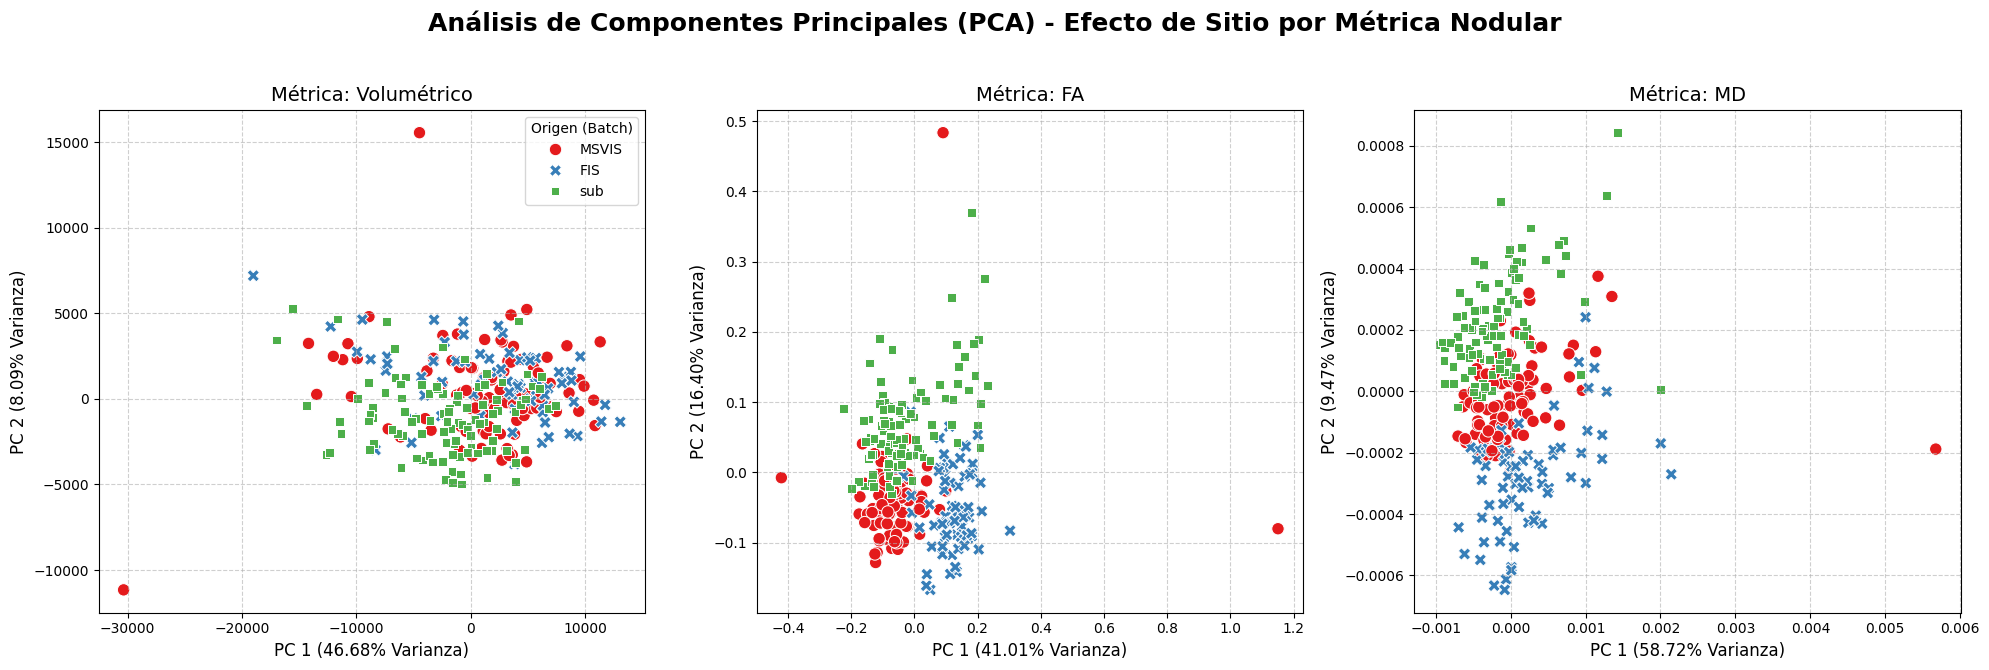

In [ ]:
generar_scatter_pca_multiple_metricas(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    sites
)

In [ ]:
def harmonize_node_data_combat(tensor_data, variables, name_batch, names_cat, null_nodes=None):
    """
    Aplica ComBat directamente al tensor de métricas por nodo (R, N_pacientes)
    para corregir el efecto del batch (protocolo de adquisición).

    Args:
        tensor_data (np.ndarray): Tensor de métricas por nodo (R, N_pacientes).
                                  R=Nodos, N=Pacientes.
        variables (pd.DataFrame): DataFrame con las variables clínicas y el batch.
        name_batch (str): Nombre de la columna de batch en variables.
        names_cat (list): Nombres de las columnas categóricas en variables.
        null_nodes (np.ndarray, optional): Vector booleano (R,) con True donde el nodo
                                           debe ser excluido de la armonización.
                                           Por defecto, se corrigen todos los nodos.

    Returns:
        np.ndarray: Tensor (R, N) corregido por el efecto de sitio.
    """
    R, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # 1. Preparación de los datos
    # La matriz de entrada para ComBat ya es el tensor (Features x Pacientes)
    dat_combat = tensor_data

    # Si hay nodos nulos, identificamos cuáles se corregirán
    if null_nodes is not None and len(null_nodes) == R:
        # Los nodos a corregir son aquellos donde null_nodes es False
        indices_to_harmonize = np.where(~null_nodes)[0]
        dat_to_harmonize = dat_combat[indices_to_harmonize, :]
    else:
        indices_to_harmonize = np.arange(R)
        dat_to_harmonize = dat_combat

    print(f"  > Datos de entrada ComBat: {dat_to_harmonize.shape} (Features x Pacientes)")

    # 2. Armonización ComBat
    # La función neuroCombat se aplica a las features (nodos) seleccionadas
    try:
        harmonized_data = neuroCombat(
            dat=dat_to_harmonize,
            covars=variables,
            batch_col=name_batch,
            categorical_cols=names_cat
        )['data']
    except NameError:
        print("\n*** ERROR: La función 'neuroCombat' no está definida. ***")
        print("Por favor, asegúrate de importar 'neuroCombat' (ej. de 'neuroHarmonize').")
        return None
    except Exception as e:
        print(f"\n*** ERROR durante la ejecución de neuroCombat: {e} ***")
        return None


    # 3. Reconstrucción del Tensor Corregido

    # Inicializar el tensor corregido con el tensor original para mantener
    # los valores de los nodos nulos (si null_nodes es provisto)
    corrected_tensor = tensor_data.copy()

    # Colocar los datos armonizados de vuelta en las filas correspondientes
    corrected_tensor[indices_to_harmonize, :] = harmonized_data

    # Nota: Si no se provee 'null_nodes', todos los nodos son armonizados,
    # y corrected_tensor será igual a harmonized_data (después de la asignación).

    print(f"  > Tensor corregido final: {corrected_tensor.shape}")
    return corrected_tensor

In [ ]:
nodos_volumetricos_tensor = harmonize_node_data_combat(nodos_volumetricos_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"])
nodos_FA_tensor = harmonize_node_data_combat(nodos_FA_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"])
nodos_MD_tensor = harmonize_node_data_combat(nodos_MD_tensor, vars_to_regression, "sites", ["sexes", "controls_mses", "mstypes"])

  > Datos de entrada ComBat: (76, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 270)
  > Datos de entrada ComBat: (76, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 270)
  > Datos de entrada ComBat: (76, 270) (Features x Pacientes)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
  > Tensor corregido final: (76, 270)


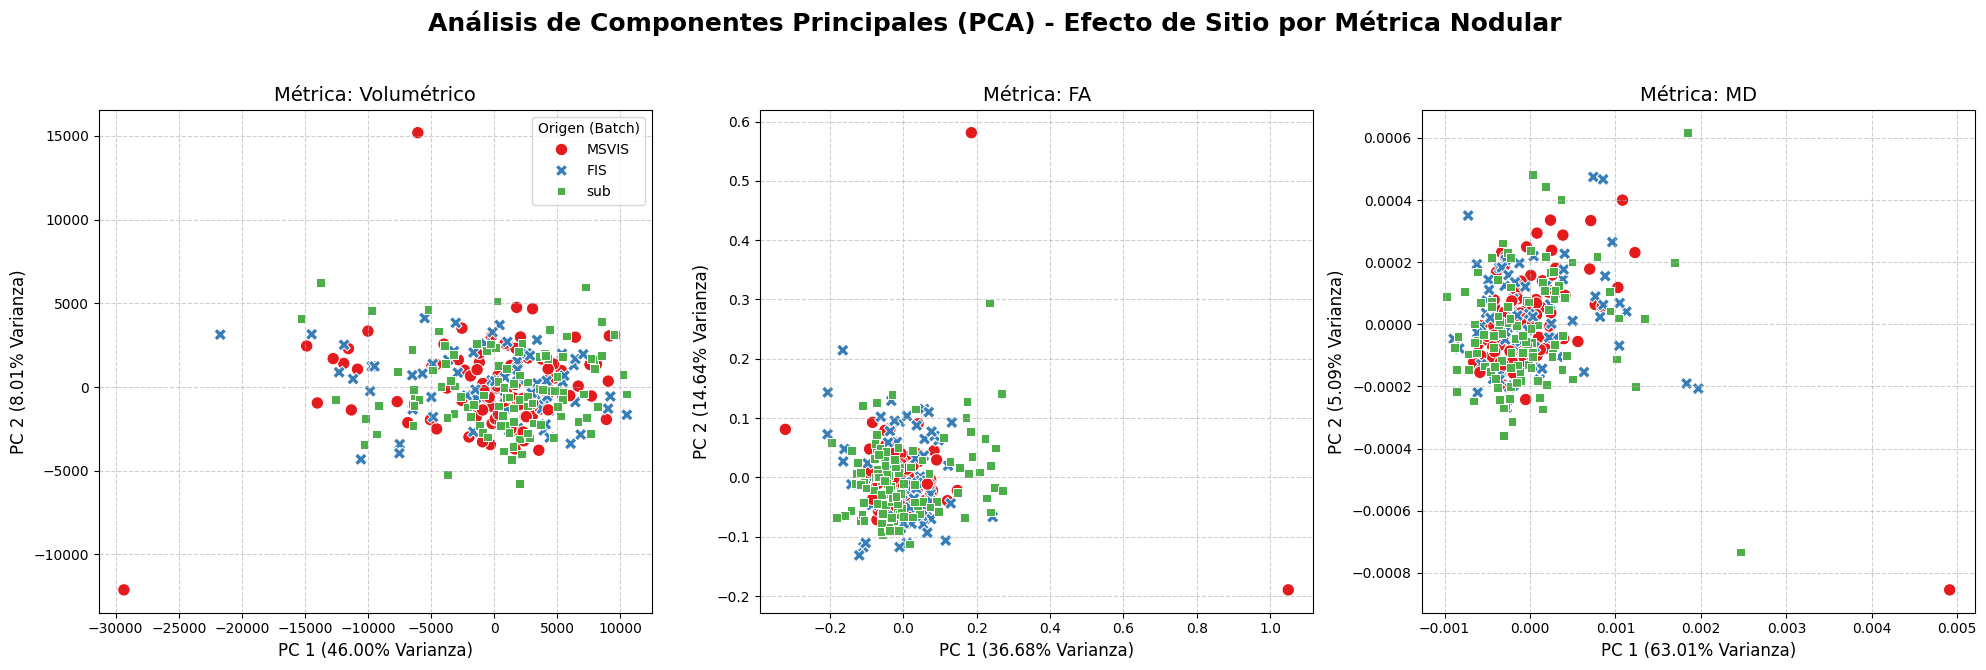

In [ ]:
generar_scatter_pca_multiple_metricas(
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    sites
)

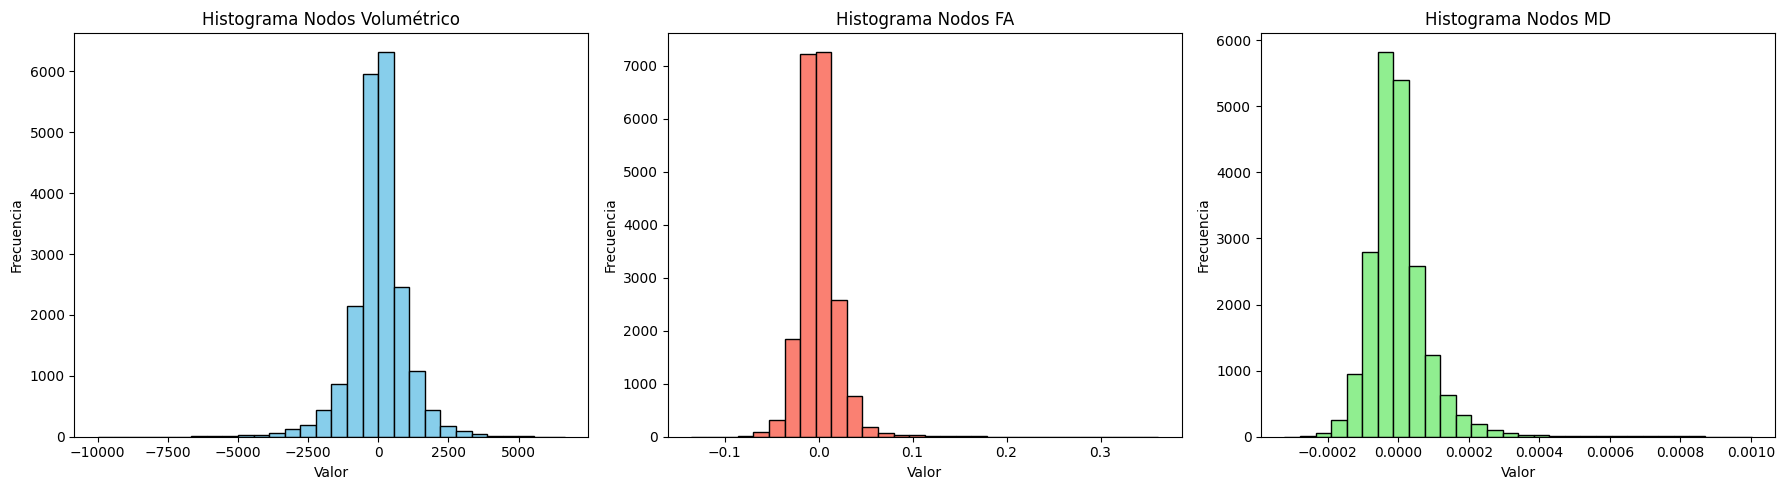

In [ ]:
# Aplanar todos los valores de nodos_volumetricos
valores_nodos_volumetricos = [valor for nodo in nodos_volumetricos_tensor for valor in nodo]
valores_nodos_volumetricos = np.array(valores_nodos_volumetricos)

# Aplanar todos los valores de nodos_FA
valores_nodos_FA = [valor for nodo in nodos_FA_tensor for valor in nodo]
valores_nodos_FA = np.array(valores_nodos_FA)

# Aplanar todos los valores de nodos_MD
valores_nodos_MD = [valor for nodo in nodos_MD_tensor for valor in nodo]
valores_nodos_MD = np.array(valores_nodos_MD)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_nodos_volumetricos, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma Nodos Volumétrico')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_nodos_FA, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma Nodos FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_nodos_MD, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma Nodos MD')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# MinMaxScaler

In [ ]:
def harmonize_tensor_data_global_minmax(tensor_data, null_conections):
    """
    Extrae todos los valores de las conexiones (triángulo superior, simetrizado)
    que NO están anuladas, aplica una normalización MinMax GLOBAL sobre ese
    conjunto de datos completo y reconstruye el tensor. Finalmente, establece
    las conexiones anuladas como np.nan.

    Args:
        tensor_data (np.ndarray): Tensor de conectividad (R, R, N_pacientes).
        null_conections (np.ndarray): Matriz booleana (R, R) con True donde
                                      la conexión fue completamente anulada.

    Returns:
        np.ndarray: Tensor 3D normalizado (MinMax global) y con conexiones nulas en nan.
    """
    R, _, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # 1. Extracción de todos los valores de las conexiones NO anuladas

    # Creamos un índice booleano 3D para identificar los valores a considerar
    # Ignoramos la diagonal (i == j) y solo consideramos el triángulo superior (i < j)
    # y las conexiones que NO están anuladas.

    # Índice de las conexiones no anuladas en el triángulo superior
    valid_conn_mask_2D = np.triu(np.logical_not(null_conections), k=1)

    # Lo expandimos a 3D para todos los pacientes
    valid_conn_mask_3D = np.repeat(valid_conn_mask_2D[:, :, np.newaxis], N, axis=2)

    # Extraemos todos los valores válidos en 1D
    # Estos son los datos sobre los que se entrenará el scaler
    valid_data_1D = tensor_data[valid_conn_mask_3D].reshape(-1, 1)

    # 2. Entrenar y aplicar el MinMax GLOBAL

    scaler = MinMaxScaler()

    # Entrenar el scaler sobre TODOS los valores válidos
    scaler.fit(valid_data_1D)

    # Aplicar la transformación a esos mismos valores
    normalized_data_1D = scaler.transform(valid_data_1D).flatten()

    # 3. Reconstrucción del tensor de salida

    # Inicializamos el tensor de salida con np.nan
    normalized_tensor = np.zeros(tensor_data.shape, dtype=float)

    # Inicializamos un contador para reinsertar los datos normalizados
    idx = 0

    # Iteramos sobre el triángulo superior para rellenar los datos
    for i in range(R):
        for j in range(i + 1, R):
            if not null_conections[i, j]:
                # Si la conexión NO está anulada, tomamos N valores normalizados
                normalized_vector = normalized_data_1D[idx : idx + N]

                # Reinsertar los datos normalizados
                normalized_tensor[i, j, :] = normalized_vector
                normalized_tensor[j, i, :] = normalized_vector  # simetría

                # Avanzamos el índice del vector 1D
                idx += N
            # Si la conexión SÍ está anulada, ya está en np.nan por la inicialización.

    # Verificación: La cantidad de datos reinsertados debe ser correcta
    # assert idx == len(normalized_data_1D)

    # 4. Manejar la diagonal (generalmente se pone a 0 o se deja en nan)
    for k in range(N):
        np.fill_diagonal(normalized_tensor[:, :, k], 0.0) # La ponemos a 0.0 por convención

    return normalized_tensor

In [ ]:
FA_matrices_tensor = harmonize_tensor_data_global_minmax(FA_matrices_tensor, FA_null_conections)
GM_matrices_tensor = harmonize_tensor_data_global_minmax(GM_matrices_tensor, GM_null_conections)
rsfMRI_matrices_tensor = harmonize_tensor_data_global_minmax(rsfMRI_matrices_tensor, rsfMRI_null_conections)

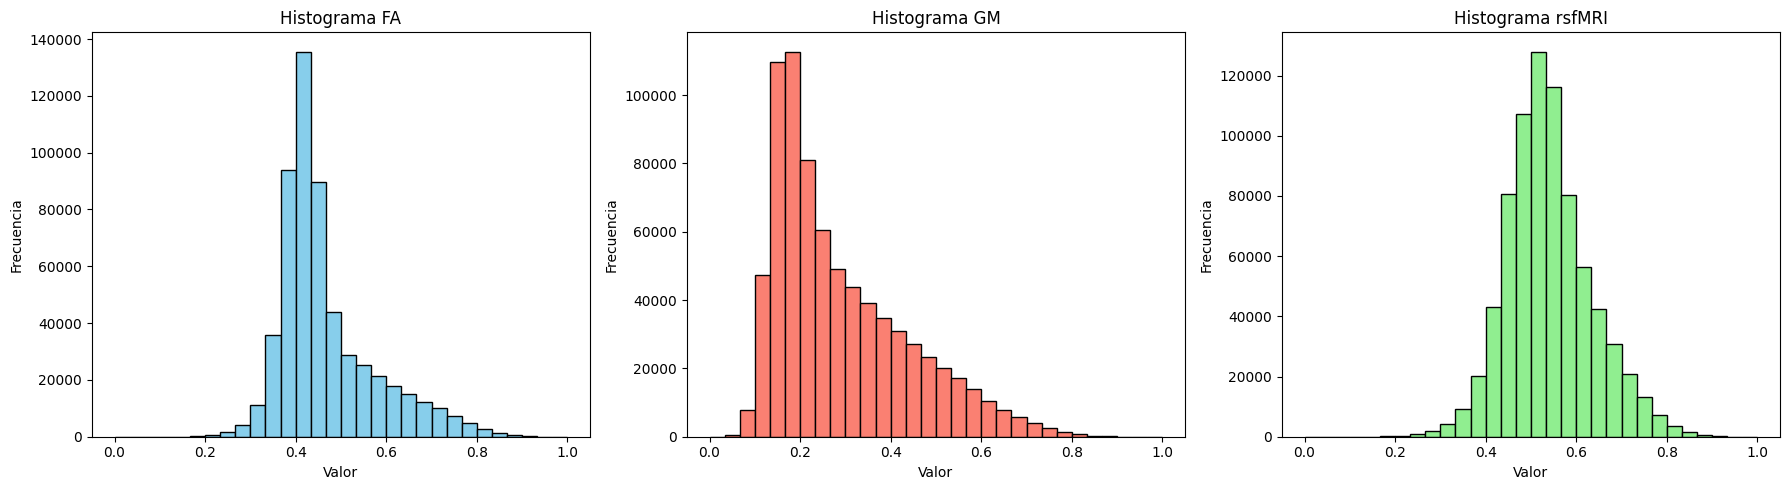

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
def harmonize_node_data_global_minmax(tensor_data, null_nodes=None):
    """
    Extrae todos los valores de los nodos (i, k) que NO están anulados,
    aplica una normalización MinMax GLOBAL sobre ese conjunto de datos completo,
    y reconstruye el tensor. Finalmente, establece los nodos anulados como np.nan.

    Args:
        tensor_data (np.ndarray): Tensor de métricas por nodo (R, N_pacientes).
                                  R=Nodos, N=Pacientes.
        null_nodes (np.ndarray, optional): Vector booleano (R,) con True donde el
                                           nodo fue completamente anulado.
                                           Por defecto, se asume que no hay nodos nulos.

    Returns:
        np.ndarray: Tensor (R, N) normalizado (MinMax global) y con nodos nulos en nan.
    """
    R, N = tensor_data.shape  # R=Nodos, N=Pacientes

    # 1. Extracción de todos los valores de los NODOS NO anulados

    # Si hay nodos nulos, creamos una máscara 2D para excluir sus valores
    if null_nodes is not None and null_nodes.shape[0] == R:
        # Crea una máscara (R, N) donde las filas correspondientes a nodos nulos son True
        # La máscara debe ser False para los nodos a considerar
        null_mask_2D = np.repeat(null_nodes[:, np.newaxis], N, axis=1)
        valid_data_1D = tensor_data[np.logical_not(null_mask_2D)].reshape(-1, 1)

        # Guardamos la máscara para la reconstrucción
        mask_2D = np.logical_not(null_mask_2D)
    else:
        # Si no hay null_nodes, todos los datos del tensor son válidos
        valid_data_1D = tensor_data.reshape(-1, 1)
        mask_2D = np.full((R, N), True) # Todos los valores son válidos para MinMax

    # 2. Entrenar y aplicar el MinMax GLOBAL

    scaler = MinMaxScaler()

    # Entrenar el scaler sobre TODOS los valores válidos
    scaler.fit(valid_data_1D)

    # Aplicar la transformación a esos mismos valores
    normalized_data_1D = scaler.transform(valid_data_1D).flatten()

    # 3. Reconstrucción del tensor de salida

    # Inicializamos el tensor de salida con np.nan
    normalized_tensor = np.full((R, N), np.nan, dtype=float)

    # Reinsertamos los datos normalizados utilizando la misma máscara
    normalized_tensor[mask_2D] = normalized_data_1D

    # Los nodos anulados (donde la máscara era False) permanecen en np.nan

    return normalized_tensor

In [ ]:
nodos_volumetricos_tensor = harmonize_node_data_global_minmax(nodos_volumetricos_tensor)
nodos_FA_tensor = harmonize_node_data_global_minmax(nodos_FA_tensor)
nodos_MD_tensor = harmonize_node_data_global_minmax(nodos_MD_tensor)

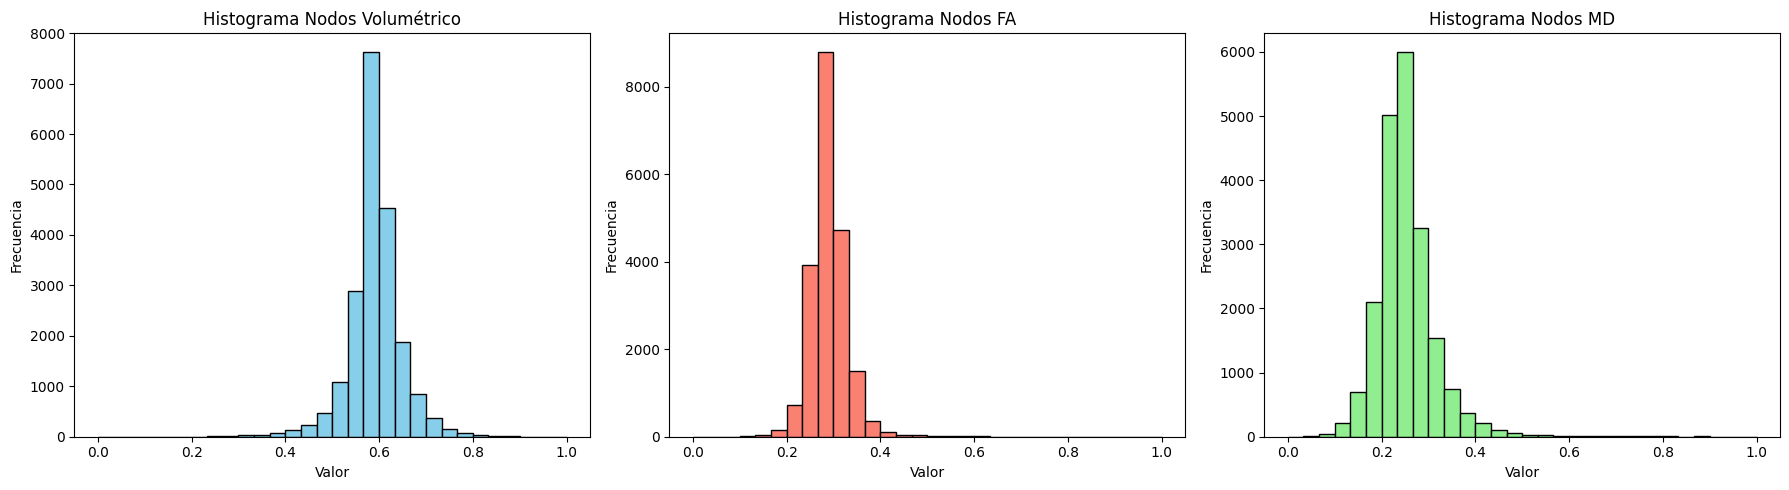

In [ ]:
# Aplanar todos los valores de nodos_volumetricos
valores_nodos_volumetricos = [valor for nodo in nodos_volumetricos_tensor for valor in nodo]
valores_nodos_volumetricos = np.array(valores_nodos_volumetricos)

# Aplanar todos los valores de nodos_FA
valores_nodos_FA = [valor for nodo in nodos_FA_tensor for valor in nodo]
valores_nodos_FA = np.array(valores_nodos_FA)

# Aplanar todos los valores de nodos_MD
valores_nodos_MD = [valor for nodo in nodos_MD_tensor for valor in nodo]
valores_nodos_MD = np.array(valores_nodos_MD)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_nodos_volumetricos, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma Nodos Volumétrico')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_nodos_FA, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma Nodos FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_nodos_MD, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma Nodos MD')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Anular las conexiones que tenian valor 0

In [ ]:
# Función para aplicar la máscara y poner 0 donde sea True
def aplicar_mascara_cero(tensor, nan_mask):
    tensor_modificado = tensor.copy()
    tensor_modificado[nan_mask] = 0
    return tensor_modificado

# Aplicar a tus tensores
FA_matrices_tensor = aplicar_mascara_cero(FA_matrices_tensor, FA_nan_mask)
GM_matrices_tensor = aplicar_mascara_cero(GM_matrices_tensor, GM_nan_mask)
rsfMRI_matrices_tensor = aplicar_mascara_cero(rsfMRI_matrices_tensor, rsfMRI_nan_mask)

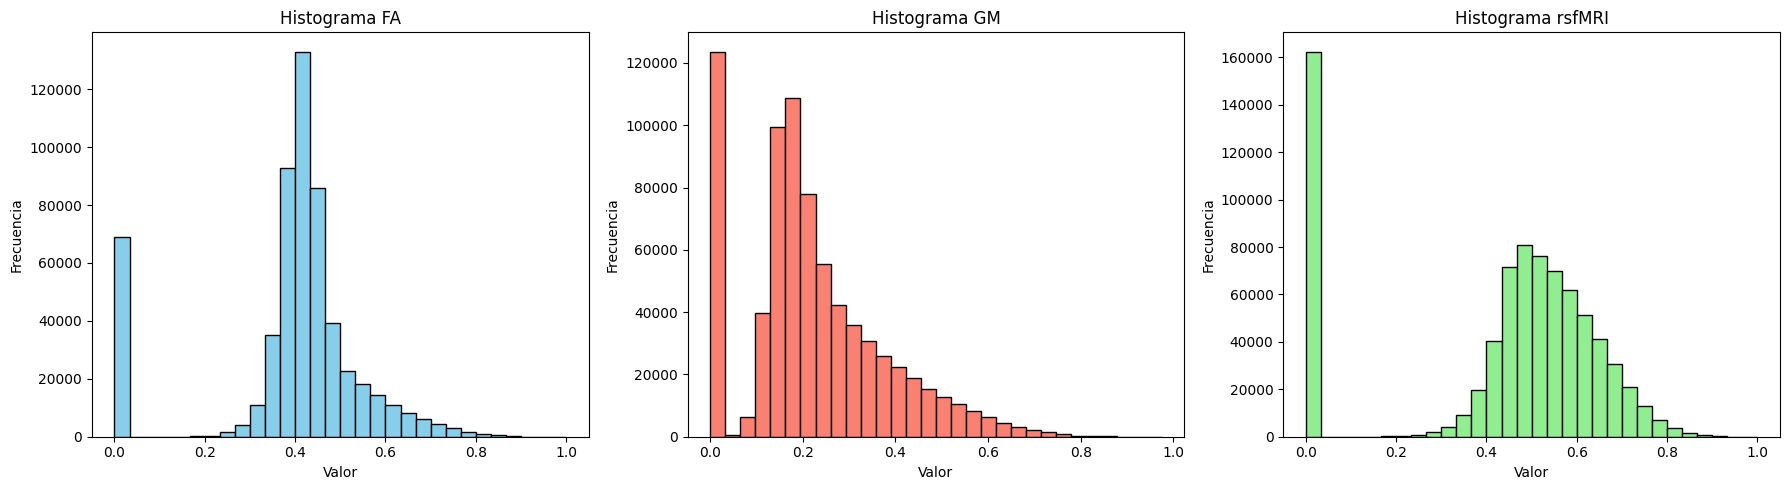

In [ ]:
# Aplicarlo a cada conjunto de matrices
valores_FA = aplanar_triangulo_superior(FA_matrices_tensor, FA_null_conections)
valores_GM = aplanar_triangulo_superior(GM_matrices_tensor, GM_null_conections)
valores_rsfMRI = aplanar_triangulo_superior(rsfMRI_matrices_tensor)

# Crear histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(valores_FA, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma FA')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(valores_GM, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma GM')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1,3,3)
plt.hist(valores_rsfMRI, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma rsfMRI')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

 # Guardar datos

In [ ]:
def procesar_y_almacenar_datos(
    FA_matrices_tensor: np.ndarray,
    GM_matrices_tensor: np.ndarray,
    rsfMRI_matrices_tensor: np.ndarray,
    nodos_volumetricos_tensor: np.ndarray,
    nodos_FA_tensor: np.ndarray,
    nodos_MD_tensor: np.ndarray,
    origenes: list,
    ids: list,
    sites: list,
    ages: list,
    sexes: list,
    ddes: list,
    edsses: list,
    controls_mses: list,
    mstypes: list,
    output_dir: str = 'DADES_CORRECTED'
):
    """
    Procesa tensores de conectividad y nodos junto con listas de información clínica
    y los almacena en archivos CSV estructurados dentro de un directorio de salida.

    Los tensores FA/GM/rsfMRI deben tener forma (i, j, k), donde k es el paciente.
    Los tensores de nodos deben tener forma (l, k), donde k es el paciente.
    Las listas de información clínica deben tener longitud k.
    """

    # 1. Configurar y crear los directorios de salida

    # Directorios base
    fa_dir = os.path.join(output_dir, 'FA_network')
    gm_dir = os.path.join(output_dir, 'GM_network')
    rsfmri_dir = os.path.join(output_dir, 'rsfmri_network')

    print(f"Creando directorios en: {output_dir}...")
    os.makedirs(fa_dir, exist_ok=True)
    os.makedirs(gm_dir, exist_ok=True)
    os.makedirs(rsfmri_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True) # Asegura que el directorio base también exista

    # El número de pacientes (k) es la longitud de las listas/última dimensión de los tensores
    # Usamos la longitud de 'ids' como referencia.
    num_pacientes = len(ids)

    # --- Guardar matrices de conectividad (Tensors i, j, k) ---

    print("Guardando matrices de conectividad...")
    for k in range(num_pacientes):
        patient_id = ids[k]
        filename = f"{patient_id}.csv"

        # FA_matrices_tensor[i, j, k] -> FA_matrices_tensor[:, :, k]
        # Se guarda el slice i,j para el paciente k
        pd.DataFrame(FA_matrices_tensor[:, :, k]).to_csv(os.path.join(fa_dir, filename),
                                                         index=False, header=False)

        # GM_matrices_tensor[i, j, k] -> GM_matrices_tensor[:, :, k]
        pd.DataFrame(GM_matrices_tensor[:, :, k]).to_csv(os.path.join(gm_dir, filename),
                                                         index=False, header=False)

        # rsfMRI_matrices_tensor[i, j, k] -> rsfMRI_matrices_tensor[:, :, k]
        pd.DataFrame(rsfMRI_matrices_tensor[:, :, k]).to_csv(os.path.join(rsfmri_dir, filename),
                                                             index=False, header=False)

    # --- Guardar datos de nodos (Tensors l, k) ---

    print("Preparando datos de nodos...")

    # Transponemos los tensores (l, k) a (k, l) para que cada fila sea un paciente
    # numpy.T o numpy.transpose(axis=(1, 0))
    vol_data_transposed = nodos_volumetricos_tensor.T
    fa_data_transposed = nodos_FA_tensor.T
    md_data_transposed = nodos_MD_tensor.T

    # Generamos los IDs de los nodos para el encabezado (l)
    num_nodos_vol = vol_data_transposed.shape[1]
    num_nodos_fa_md = fa_data_transposed.shape[1]

    node_cols_vol = [f"vol_node_{l+1}" for l in range(num_nodos_vol)]
    node_cols_fa_md = [f"fa_md_node_{l+1}" for l in range(num_nodos_fa_md)]

    # Creamos los DataFrames para los nodos

    # NODES.csv (Nodos Volumétricos)
    df_vol = pd.DataFrame(data=vol_data_transposed, columns=node_cols_vol)
    df_vol.insert(0, 'ID', ids) # Añadimos 'ids[k]' como primera columna
    df_vol.to_csv(os.path.join(output_dir, 'NODES.csv'), index=False)

    # GM_FA.csv (Nodos FA)
    df_fa = pd.DataFrame(data=fa_data_transposed, columns=node_cols_fa_md)
    df_fa.insert(0, 'ID', ids)
    df_fa.to_csv(os.path.join(output_dir, 'GM_FA.csv'), index=False)

    # GM_MD.csv (Nodos MD)
    df_md = pd.DataFrame(data=md_data_transposed, columns=node_cols_fa_md)
    df_md.insert(0, 'ID', ids)
    df_md.to_csv(os.path.join(output_dir, 'GM_MD.csv'), index=False)

    # --- Guardar información clínica (Listas de longitud k) ---

    print("Guardando información clínica...")

    # Creamos un diccionario para el DataFrame clínico
    clinic_data = {
        'ids': ids,
        'origenes': origenes,
        'sites': sites,
        'ages': ages,
        'sexes': sexes,
        'ddes': ddes,
        'edsses': edsses,
        'controls_mses': controls_mses,
        'mstypes': mstypes
    }

    # Creamos el DataFrame
    df_clinic = pd.DataFrame(clinic_data)

    # Guardamos en CLINIC.csv
    df_clinic.to_csv(os.path.join(output_dir, 'CLINIC.csv'), index=False)

    print(f"Proceso completado. Archivos guardados en el directorio: {output_dir}")

In [ ]:
procesar_y_almacenar_datos(
    FA_matrices_tensor,
    GM_matrices_tensor,
    rsfMRI_matrices_tensor,
    nodos_volumetricos_tensor,
    nodos_FA_tensor,
    nodos_MD_tensor,
    origenes,
    ids,
    sites,
    ages,
    sexes,
    ddes,
    edsses,
    controls_mses,
    mstypes
)

Creando directorios en: DADES_CORRECTED...
Guardando matrices de conectividad...
Preparando datos de nodos...
Guardando información clínica...
Proceso completado. Archivos guardados en el directorio: DADES_CORRECTED
